# Genome-wide admixture analysis with MendelImpute and ADMIXTURE

Here is the code for filtering all chromosomes in 1000 genomes project. We will use samples from:

- MXL: Mexican Ancestry in Los Angeles
- PUR: Puerto Rican in Puerto Rico
- ASW: African Ancestry in SW USA
- CLM: Colombian in Medellin, Colombia
- PEL: Peruvian in Lima, Peru
- ACB: African Caribbean in Barbados

as targets to infer ancestry. These population ($n = 504$) show high degrees of recent admixture and are also highly heterogeneous in their admixture. Remaining samples ($n = 2000$) will be used as the reference panel. Deatailed population description is found [here](https://www.coriell.org/1/NHGRI/About/Guidelines-for-Referring-to-Populations). 

## Run on each chromosome

In [1]:
using Revise
using VCFTools
using SnpArrays
using MendelImpute
using VariantCallFormat
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using StatsPlots
using DelimitedFiles
using JLSO
using StatsBase
using ADMIXTURE
using CSV, DataFrames
BLAS.set_num_threads(1)
# cd("/u/scratch/b/biona001/admixture")

function filter_and_mask(chr::Int)
    data = "./chr$chr.1kg.phase3.v5a.vcf.gz"

    # maps sample ID to 26 populations
    refID_to_population = thousand_genome_samples_to_population()

    # need full sample ID list
    sampleIDs = sampleID(data)

    # check how many people remain in reference panel
    admixed = ["MXL", "PUR", "CLM", "PEL", "ASW", "ACB"]
    ref_idx = Int[]
    sample_idx = Int[]
    for (i, id) in enumerate(sampleIDs)
        refID_to_population[id] ∈ admixed ? push!(sample_idx, i) : push!(ref_idx, i)
    end
    @show length(ref_idx)
    @show length(sample_idx)

    # filter chromosome data for unique snps
    full_record_index = .!find_duplicate_marker(data)
    VCFTools.filter(data, full_record_index, 1:nsamples(data), 
        des = "chr$chr.uniqueSNPs.vcf.gz")

    # summarize data
    total_snps = nrecords("chr$chr.uniqueSNPs.vcf.gz")
    samples = nsamples("chr$chr.uniqueSNPs.vcf.gz")

    # generate target panel with all snps
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        sample_idx, des = "target.chr$chr.full.vcf.gz", allow_multiallelic=false)

    # also generate reference panel
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        ref_idx, des = "ref.chr$chr.vcf.gz", allow_multiallelic=false)

    # set top 50k ancestry informative marker as typed SNPs
    p = 50000
    aim_pvals = VCFTools.aim_select("chr$chr.uniqueSNPs.vcf.gz", refID_to_population)
    writedlm("chr$chr.aim.pvals", aim_pvals)
    aim_rank = sortperm(aim_pvals)
    record_idx = falses(total_snps)
    [record_idx[aim_rank[i]] = true for i in 1:p] # typed SNPs are top aim markers
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
        des = "target.chr$chr.typedOnly.aim.vcf.gz", allow_multiallelic=false)

    # unphase and mask 1% entries in target file
    n = length(sample_idx)
    masks = falses(p, n)
    missingprop = 0.001
    for j in 1:n, i in 1:p
        rand() < missingprop && (masks[i, j] = true)
    end
    mask_gt("target.chr$chr.typedOnly.aim.vcf.gz", masks, 
        des="target.chr$chr.typedOnly.aim.masked.vcf.gz", unphase=true)

    # Compress reference file to VCF
    d = 1000
    @time compress_haplotypes("ref.chr$chr.vcf.gz", "target.chr$chr.typedOnly.aim.masked.vcf.gz",
        "ref.chr$chr.jlso", d)
end

function infer_ancestry(chr::Int)
    # get 1000 genome's population information
    refID_to_superpopulation = thousand_genome_samples_to_super_population()

    # compute each person's phase information
    Random.seed!(2020)
    tgtfile = "target.chr$chr.typedOnly.aim.masked.vcf.gz"
    reffile = "ref.chr$chr.jlso"
    outfile = "mendelimpute.chr$chr.ancestry.Q"
    continent = ["SAS", "EAS", "EUR", "AFR"]
    Qmendel = admixture_global(tgtfile, reffile, refID_to_superpopulation, continent, Q_outfile=outfile)

    # 3 selected sample's composition (PUR, PEL, ASW)
    tgtID = sampleID(tgtfile)
    sample1 = findfirst(isequal("HG00553"), tgtID)
    sample2 = findfirst(isequal("HG02348"), tgtID)
    sample3 = findfirst(isequal("NA20356"), tgtID)
    sample1_comp = Qmendel[sample1, :]
    sample2_comp = Qmendel[sample2, :]
    sample3_comp = Qmendel[sample3, :]

    # compute sample composition using ADMIXTURE
    vcf2plink(tgtfile, "target.chr$chr.typedOnly.aim.masked")

    # run ADMIXTURE with K = 4
    P, Q = admixture("target.chr$chr.typedOnly.aim.masked.bed", 4);
    
    open("chr$chr.admixture.summary", "w") do io
        println(io, "MendelImpute result:")
        println(io, "sample 1 = ", round(sample1_comp[1], digits=3), " S. asian")
        println(io, "sample 1 = ", round(sample1_comp[2], digits=3), " E. asian")
        println(io, "sample 1 = ", round(sample1_comp[3], digits=3), " European")
        println(io, "sample 1 = ", round(sample1_comp[4], digits=3), " Africans\n")

        println(io, "sample 2 = ", round(sample2_comp[1], digits=3), " S. asian")
        println(io, "sample 2 = ", round(sample2_comp[2], digits=3), " E. asian")
        println(io, "sample 2 = ", round(sample2_comp[3], digits=3), " European")
        println(io, "sample 2 = ", round(sample2_comp[4], digits=3), " Africans\n")

        println(io, "sample 3 = ", round(sample3_comp[1], digits=3), " S. asian")
        println(io, "sample 3 = ", round(sample3_comp[2], digits=3), " E. asian")
        println(io, "sample 3 = ", round(sample3_comp[3], digits=3), " European")
        println(io, "sample 3 = ", round(sample3_comp[4], digits=3), " Africans\n")
        
        println(io, "ADMIXTURE result:")
        println(io, "Q1 = ", Q[sample1, :])
        println(io, "Q2 = ", Q[sample2, :])
        println(io, "Q3 = ", Q[sample3, :])
    end
end

function infer_ancestry_test()
    # get 1000 genome's population information
    refID_to_superpopulation = thousand_genome_samples_to_super_population()
    
    for chr in 1:23
        try
            tgtfile = "target.chr$chr.typedOnly.aim.masked.vcf.gz"
            reffile = "ref.chr$chr.jlso"
            admixture_global(tgtfile, reffile, refID_to_superpopulation)
            mv("mendelimpute.ancestry.Q", "mendelimpute.chr$chr.ancestry.Q")
        catch
            continue
        end
    end
end

# chr = parse(Int, ARGS[1])
# @time filter_and_mask(chr)
# @time infer_ancestry(chr)

infer_ancestry_test (generic function with 1 method)

# Global ancestry estimates

Note we picked 4 colors so that they are distinguishable even when converted to black and white.

In [1]:
function global_Q()
    Q_mendel_avg = zeros(504, 4)
    Q_admixture_avg = zeros(504, 4)
    
    tgt_ids = sampleID("target.chr18.full.vcf.gz")
    id_to_population = thousand_genome_samples_to_population()
    tgt_pop = [id_to_population[id] for id in tgt_ids]
    p = sortperm(tgt_pop)
    
    total_chroms = 0
    for chr in 1:23
        isfile("mendelimpute.chr$chr.ancestry.Q") || continue
        isfile("target.chr$chr.typedOnly.aim.masked.4.Q") || continue
        
        # update mendel's Q
        Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
        Q_mendel_avg += Matrix(Q_mendel[p, :])
        
        # update admixture's Q
        Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
        q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]

        ### Note these orders are determined by chromosome plots below!!!
        if chr in [1, 3, 4, 6, 11, 12, 14, 15, 16, 19]
            Q_admixture_avg += [q1 q4 q2 q3]
        elseif chr in [5, 7, 8, 9, 10, 13, 17, 18, 20, 21, 22]
            Q_admixture_avg += [q3 q4 q2 q1]
        else
            error("shouldn't have reached here")
        end
        total_chroms += 1
    end
    
    Q_mendel_avg ./= total_chroms
    Q_admixture_avg ./= total_chroms
    
    return Q_mendel_avg , Q_admixture_avg
end

global_Q (generic function with 1 method)

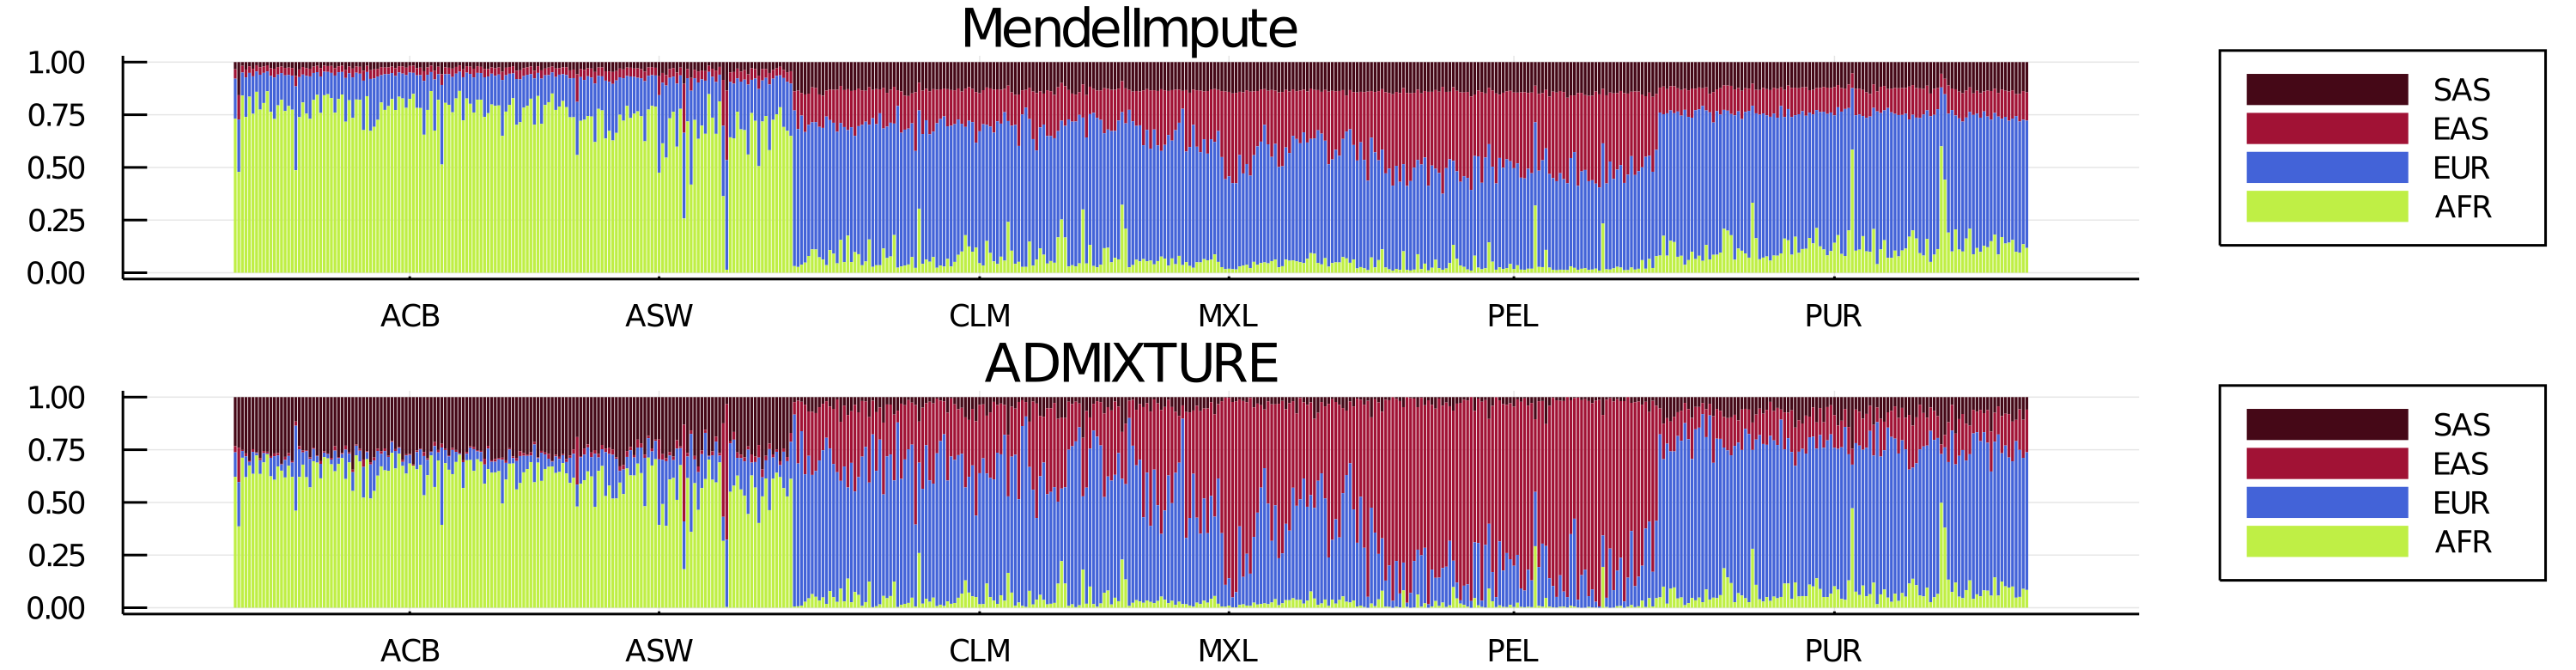

In [2]:
using StatsPlots, MendelImpute, VCFTools, CSV, DataFrames, DelimitedFiles
tgt_ids = sampleID("target.chr18.full.vcf.gz")
id_to_population = thousand_genome_samples_to_population()
tgt_pop = [id_to_population[id] for id in tgt_ids]

Q_mendel_avg , Q_admixture_avg = global_Q()
colors = [colorant"#450817" colorant"#a11235" colorant"#4363d8" colorant"#bfef45"]
populations = ["SAS" "EAS" "EUR" "AFR"]

# MendelImpute
plt1 = groupedbar(Q_mendel_avg, linecolor=nothing, bar_position = :stack, 
    size=(1000, 130), title="MendelImpute", label=populations, legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=colors)

# ADMIXTURE
plt2 = groupedbar(Q_admixture_avg, linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130), label=populations, legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=colors)

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "global.comparison.png")
display("image/png", read("global.comparison.png"))

# Compare chromosome by chromosome

Since ADMIXTURE estimates ancestry proportions without labels, we must plot each chromosome individually and assign colors to them first, before computing averages in the global average plot.

In [4]:
tgt_ids = sampleID("target.chr18.full.vcf.gz")
id_to_population = thousand_genome_samples_to_population()
tgt_pop = [id_to_population[id] for id in tgt_ids]
idx = [1,2,3,5] # don't include col 4 = admixed American
p = sortperm(tgt_pop);

In [6]:
tgt_pop

504-element Vector{String}:
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 ⋮
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"
 "ASW"

## Chrom 1

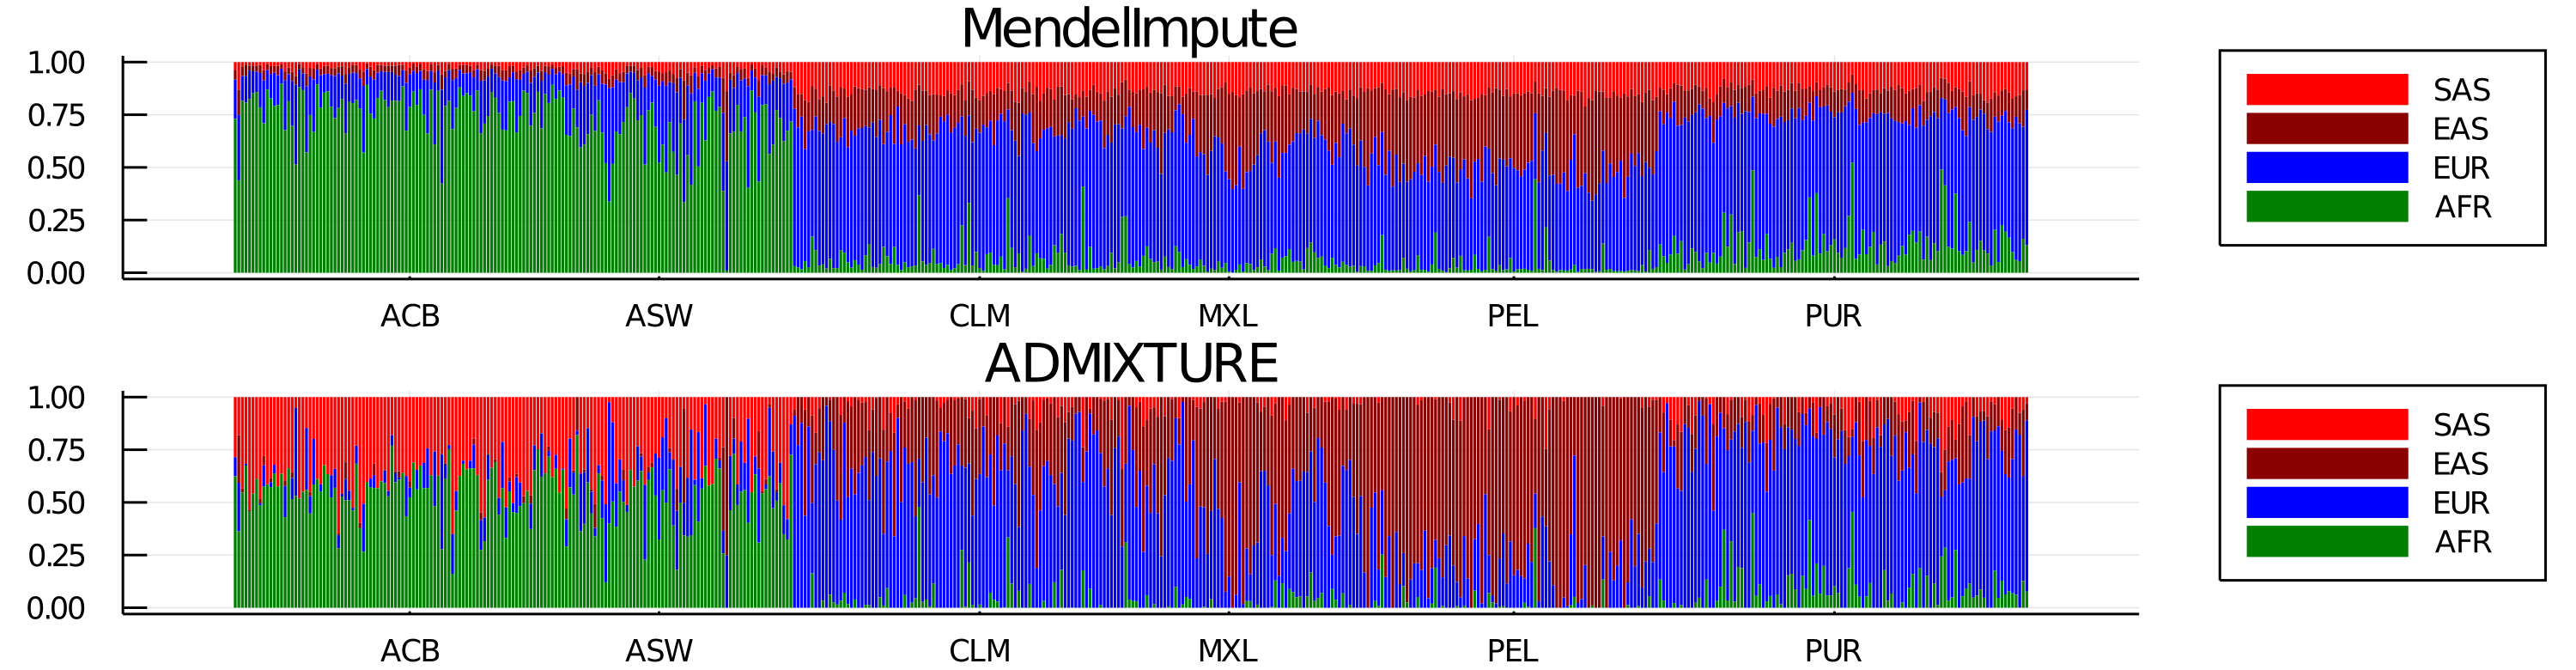

In [34]:
chr = 1

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 3

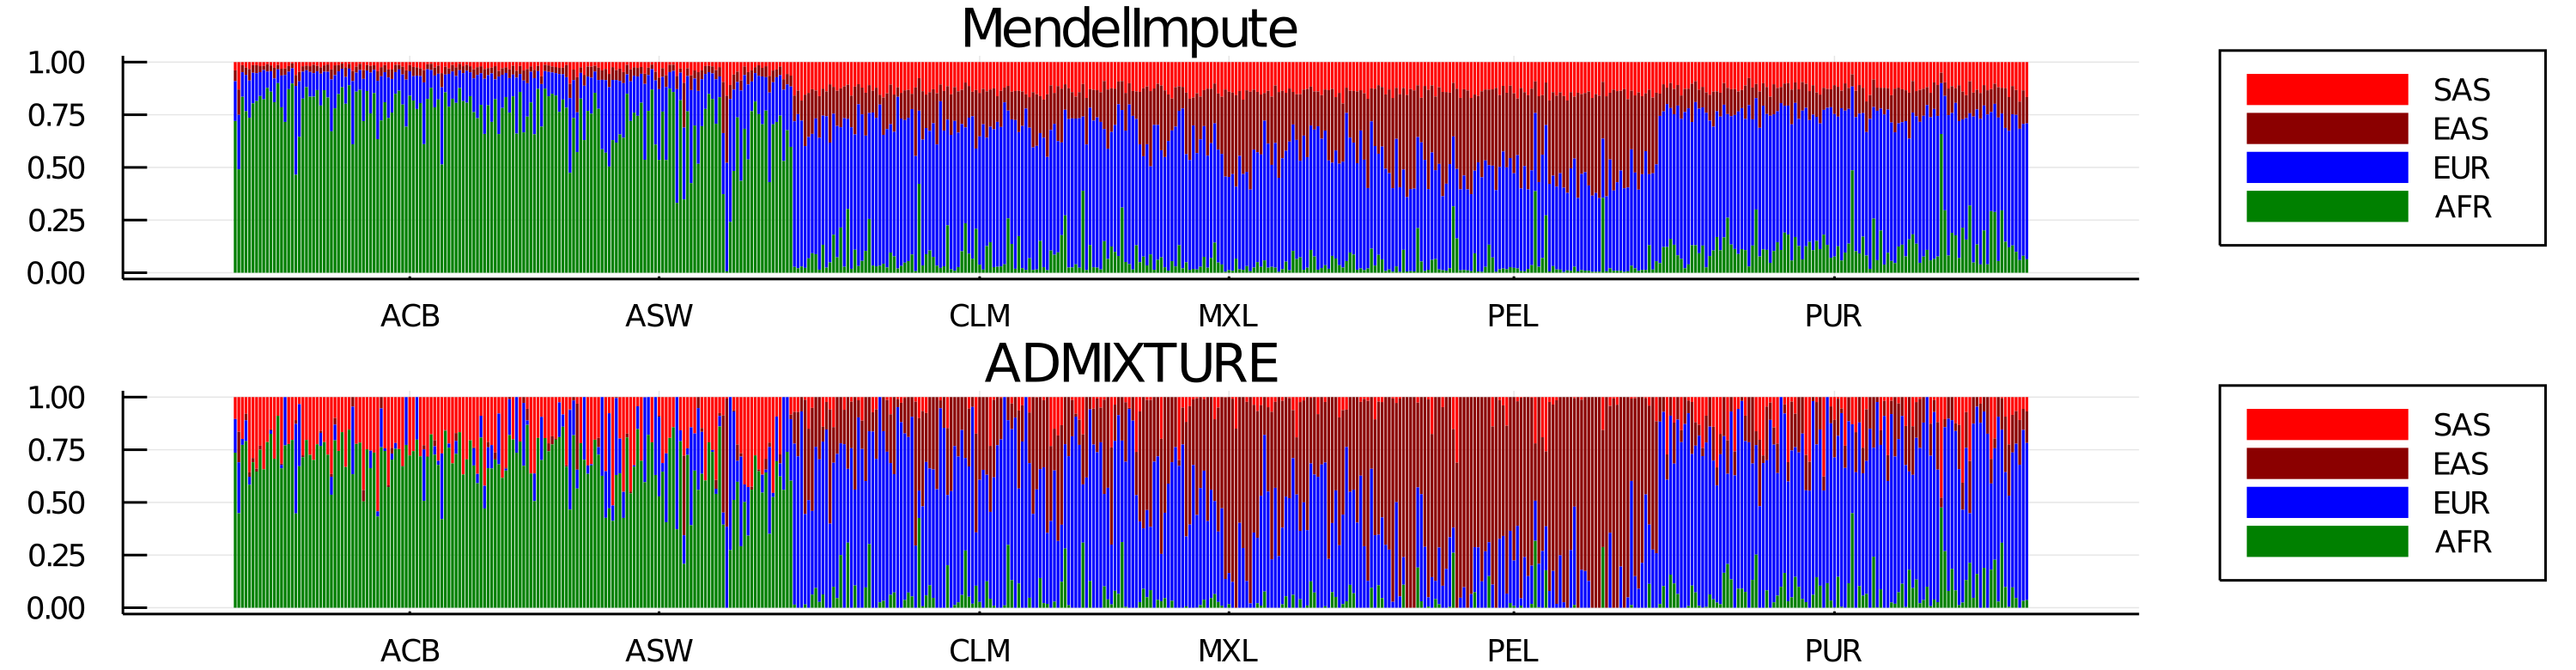

In [35]:
chr = 3

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 4

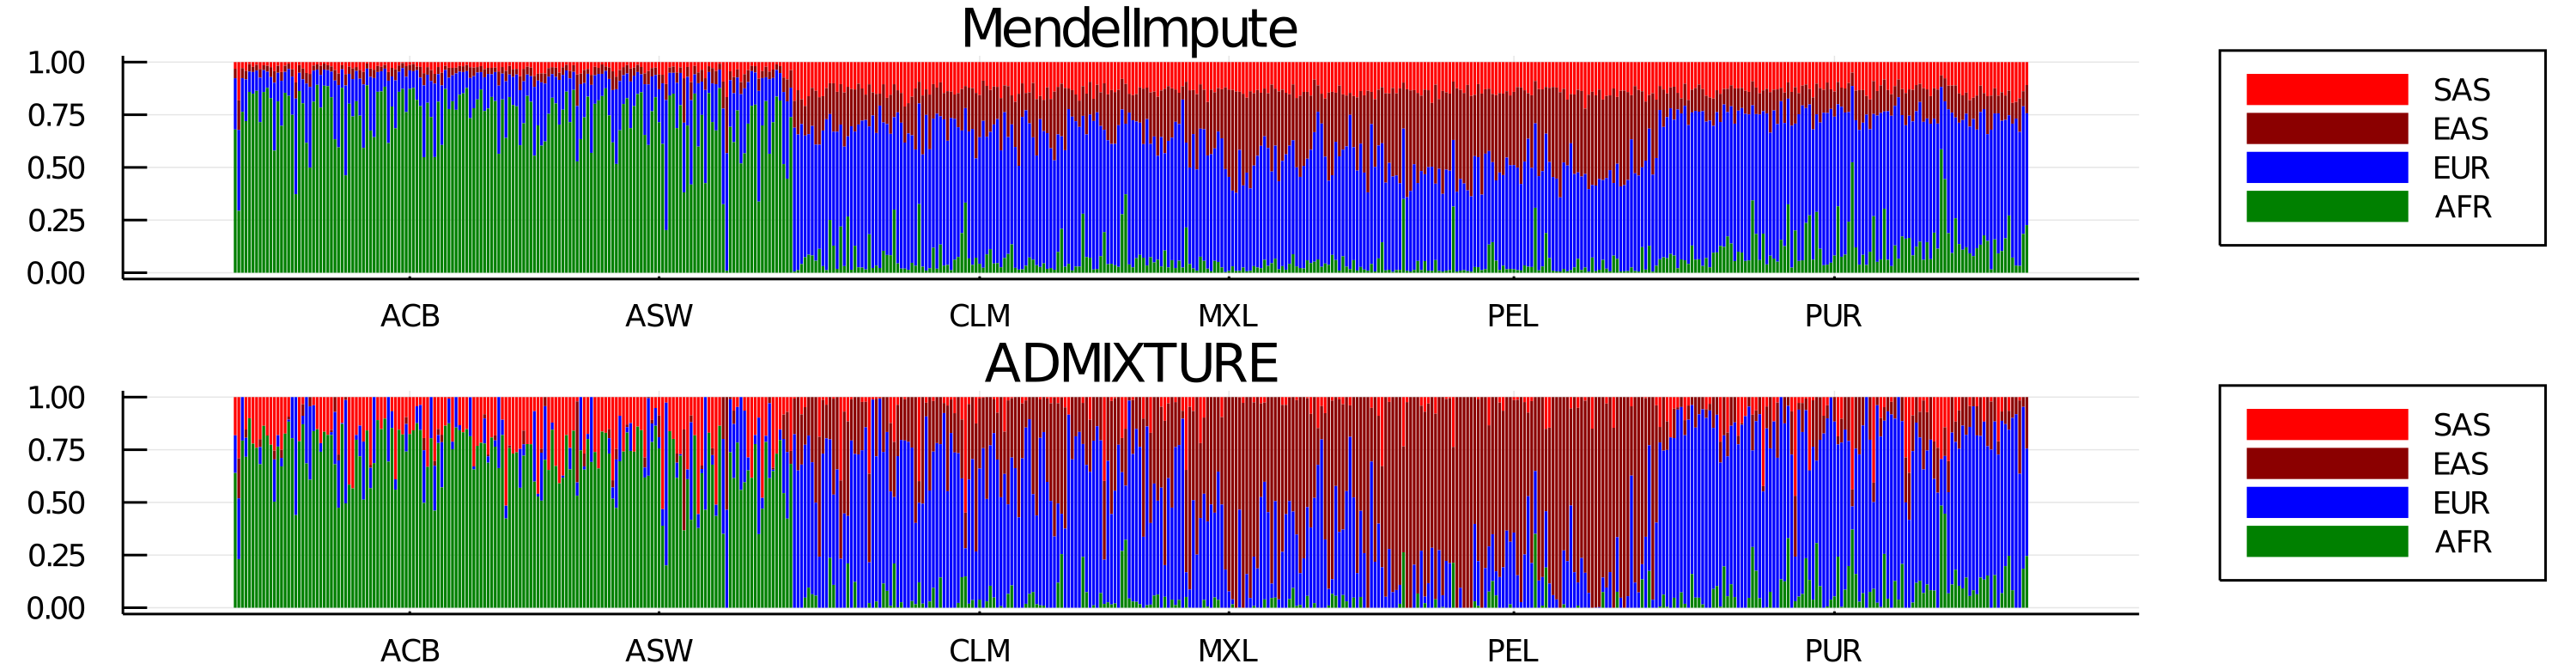

In [38]:
chr = 4

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 5

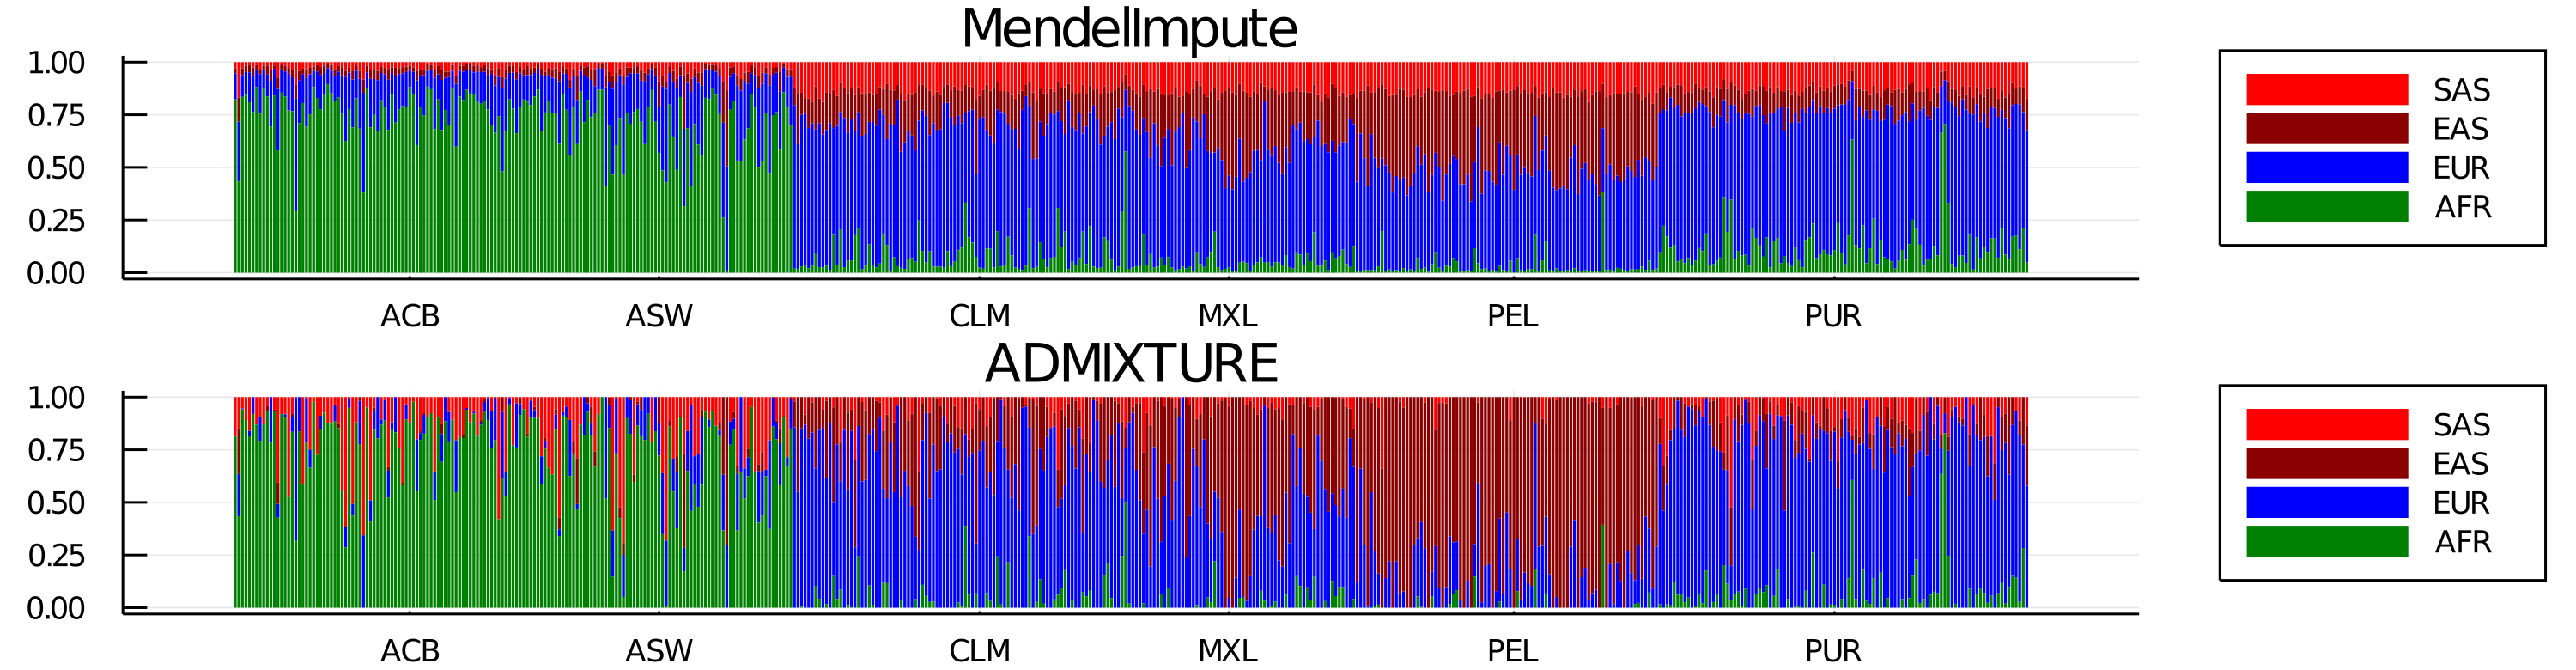

In [59]:
chr = 5

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 6

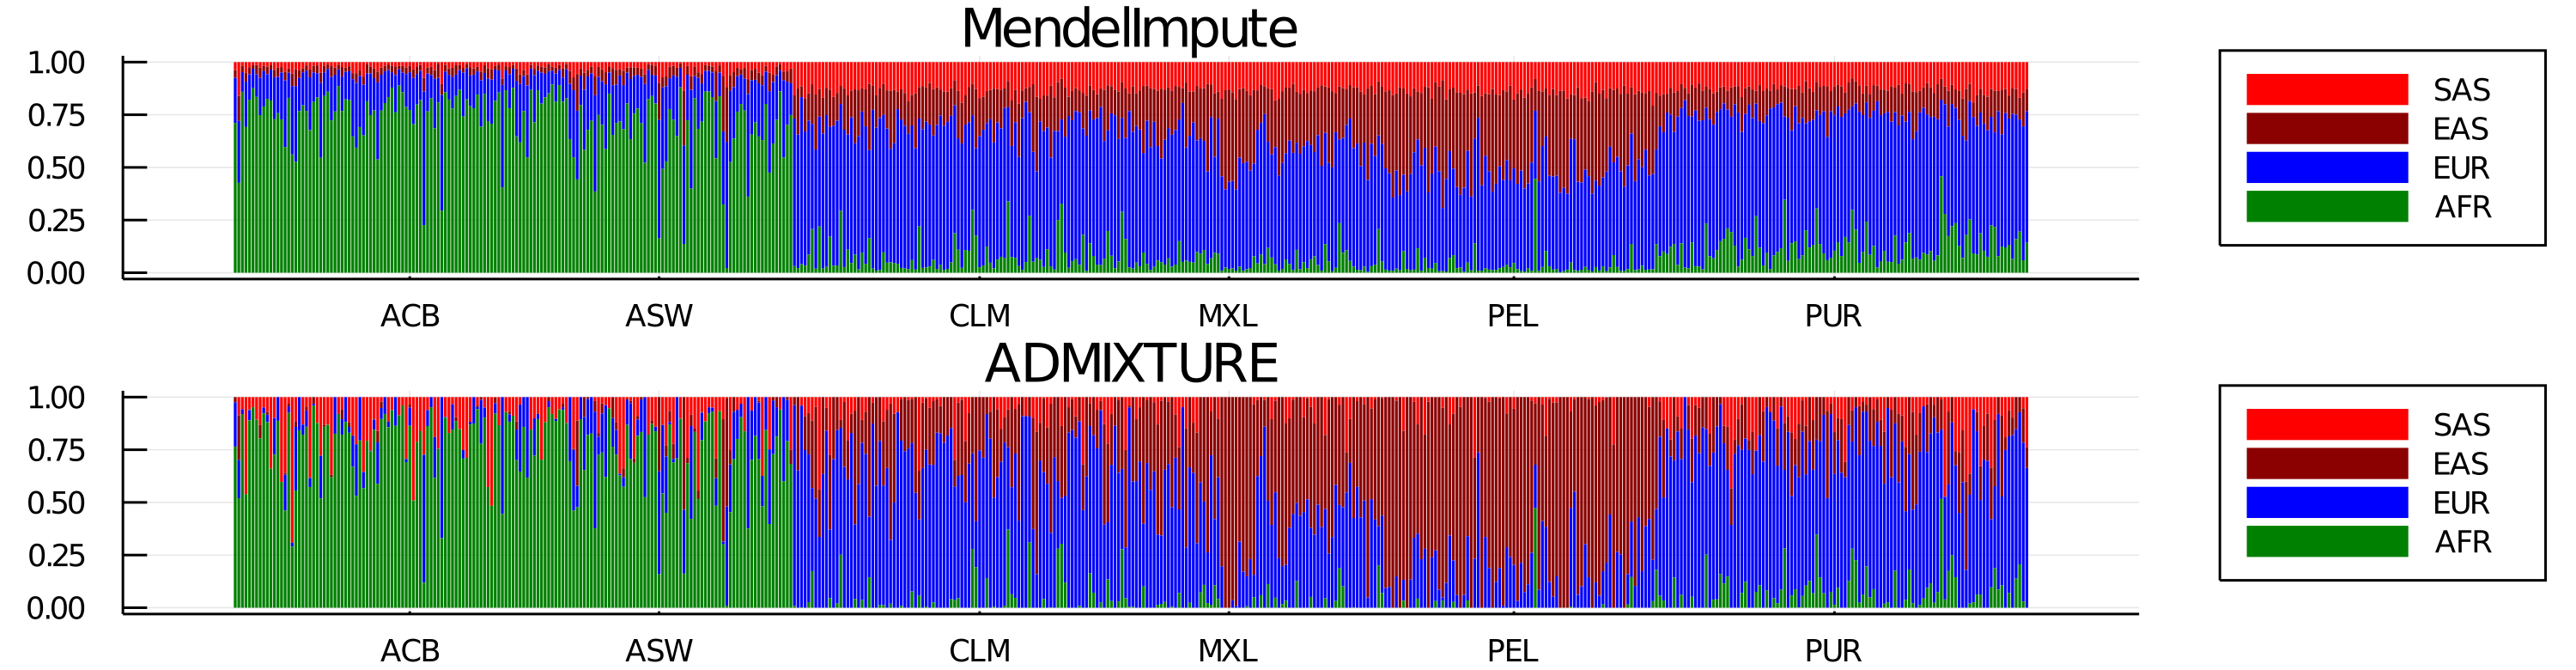

In [77]:
chr = 6

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 7

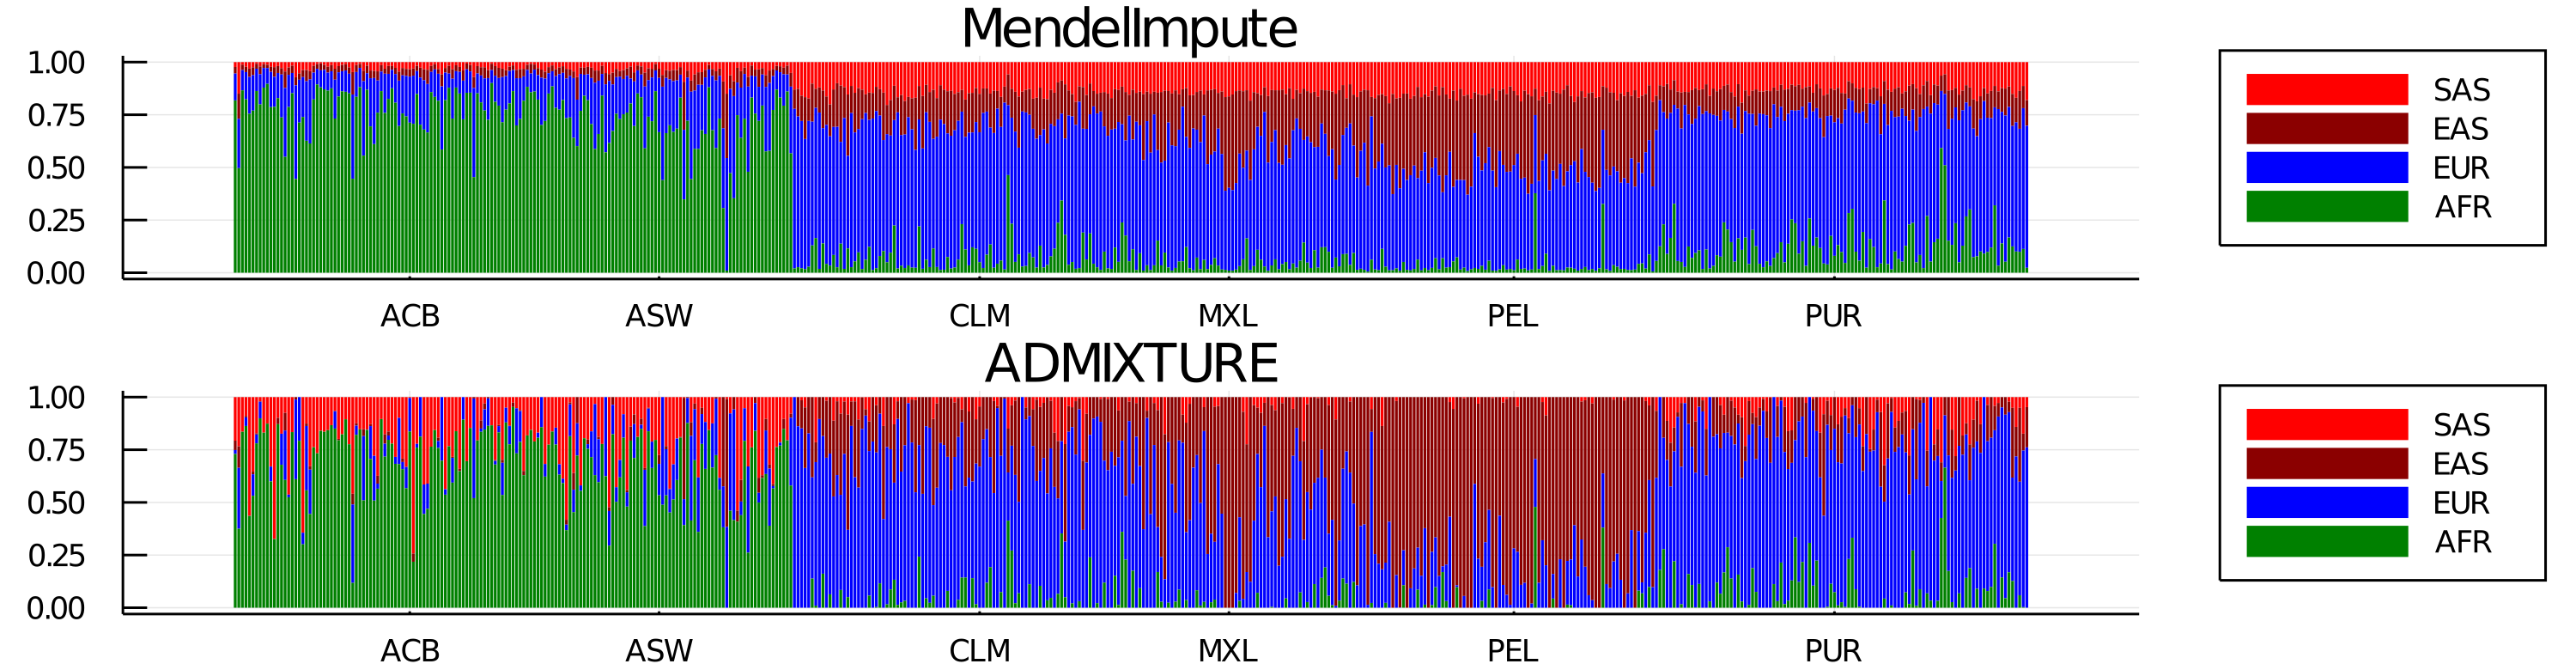

In [60]:
chr = 7

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 8

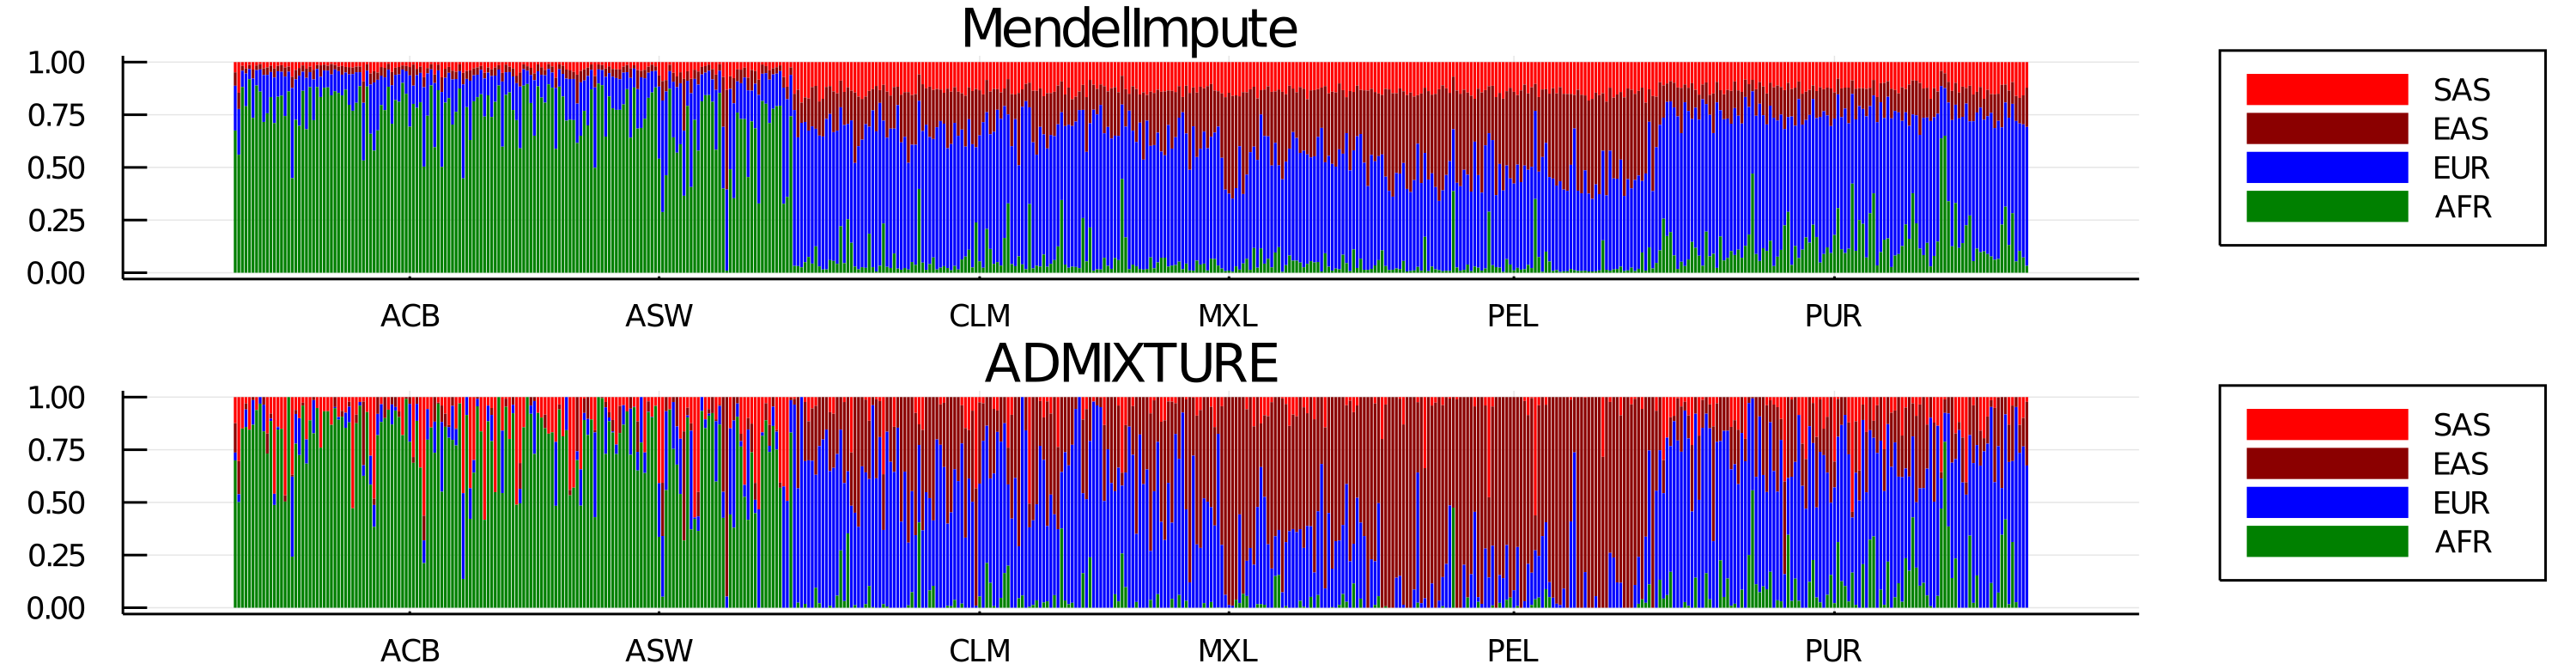

In [61]:
chr = 8

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 9

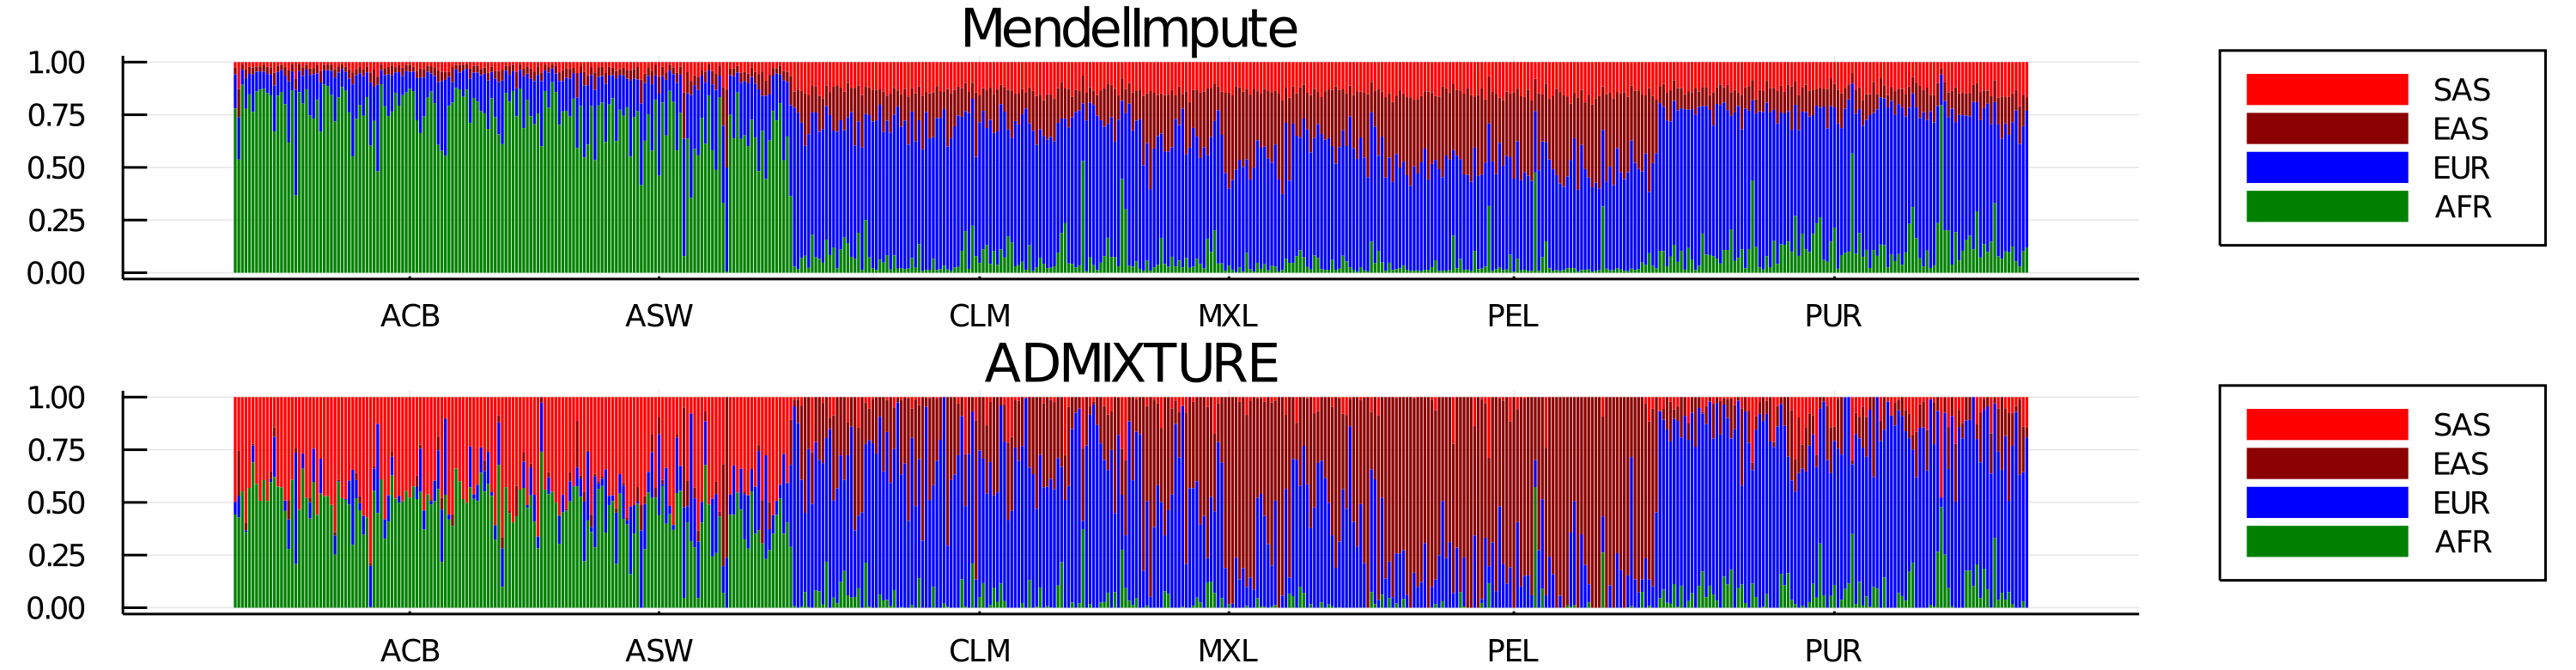

In [66]:
chr = 9

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 10

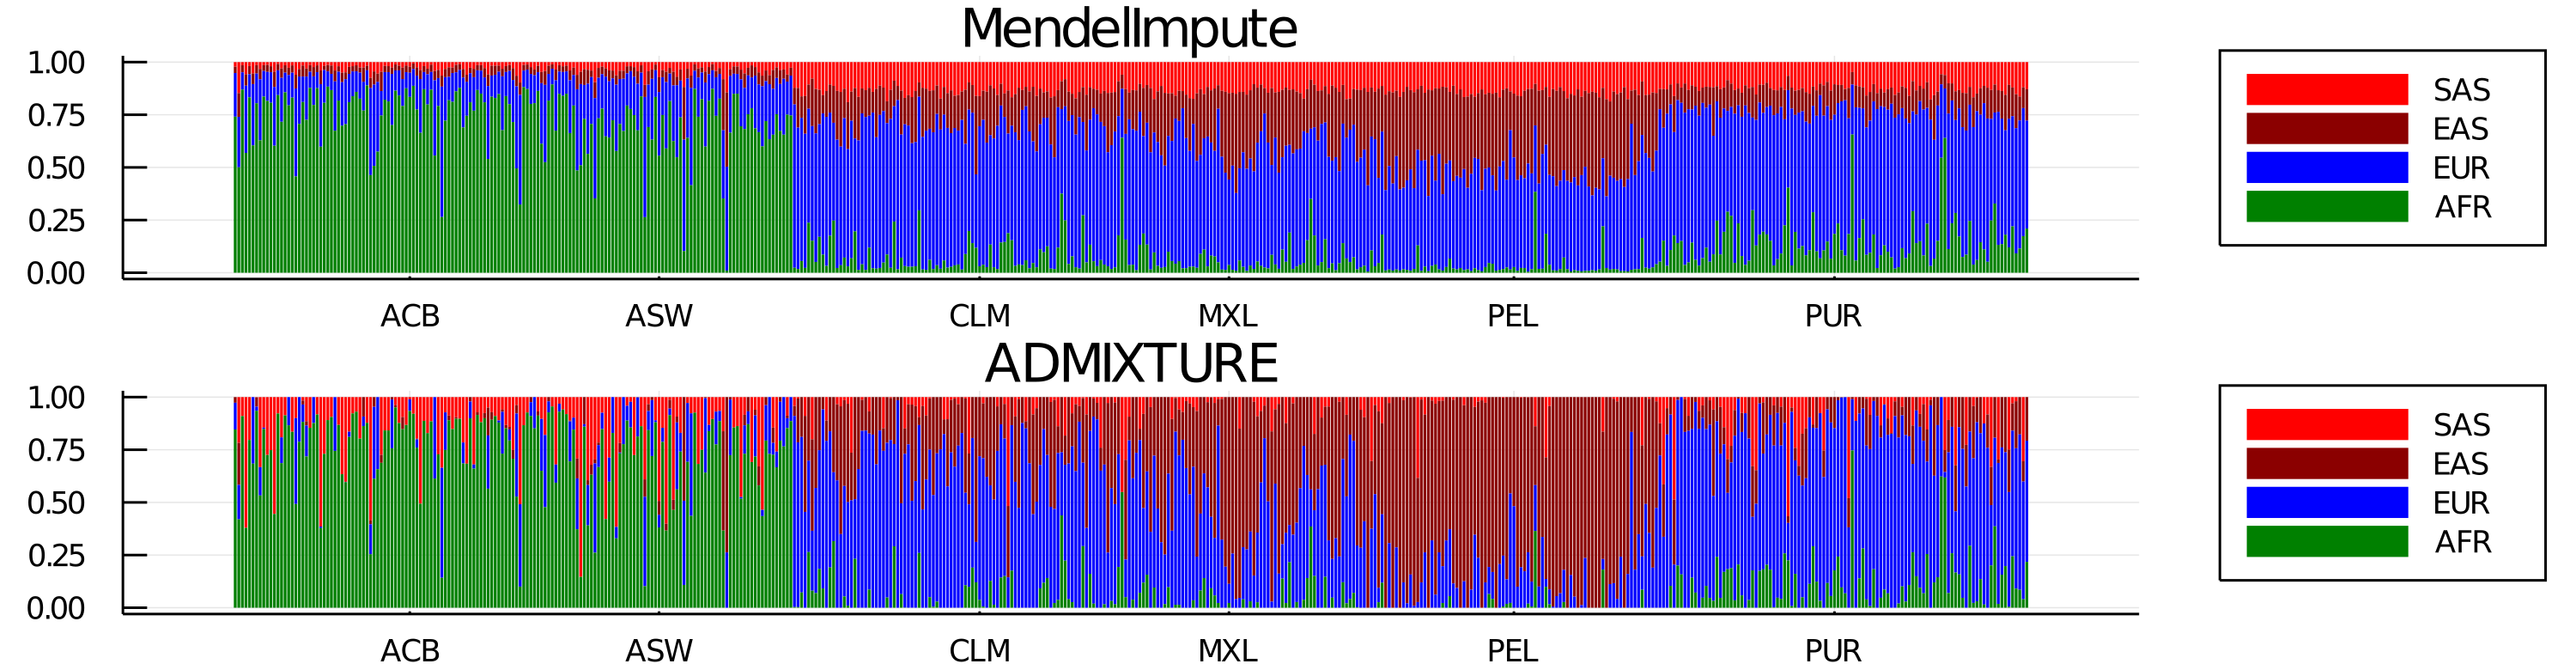

In [67]:
chr = 10

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 11

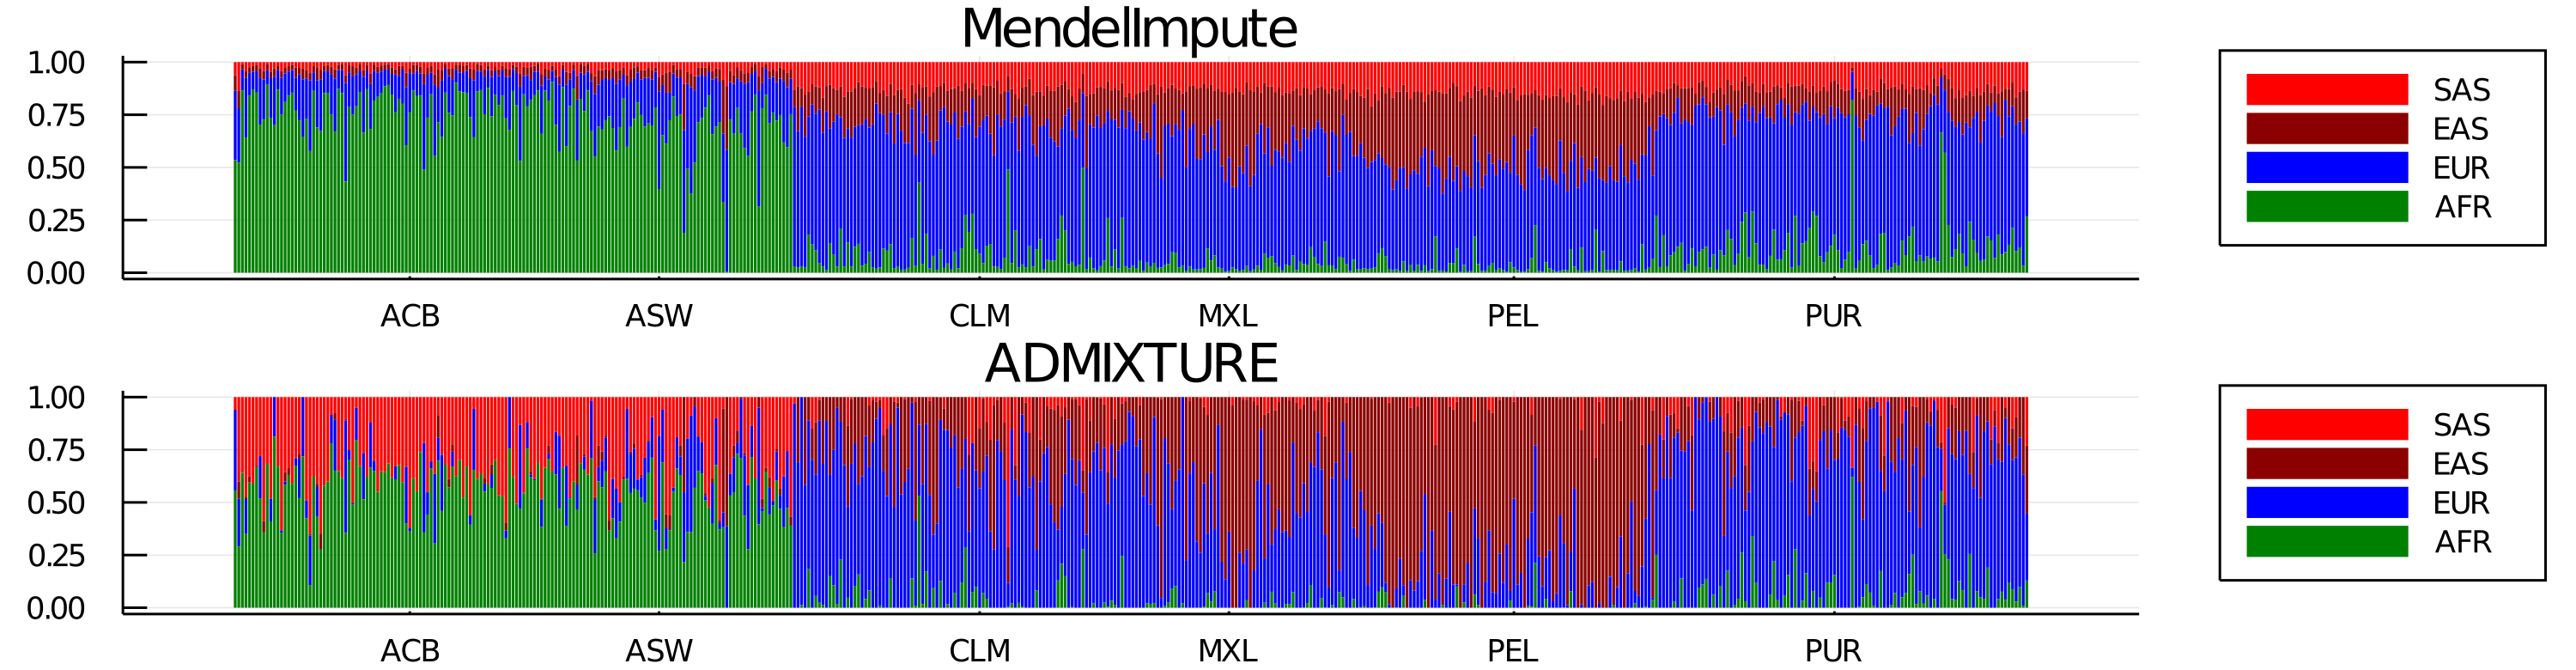

In [45]:
chr = 11

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 12

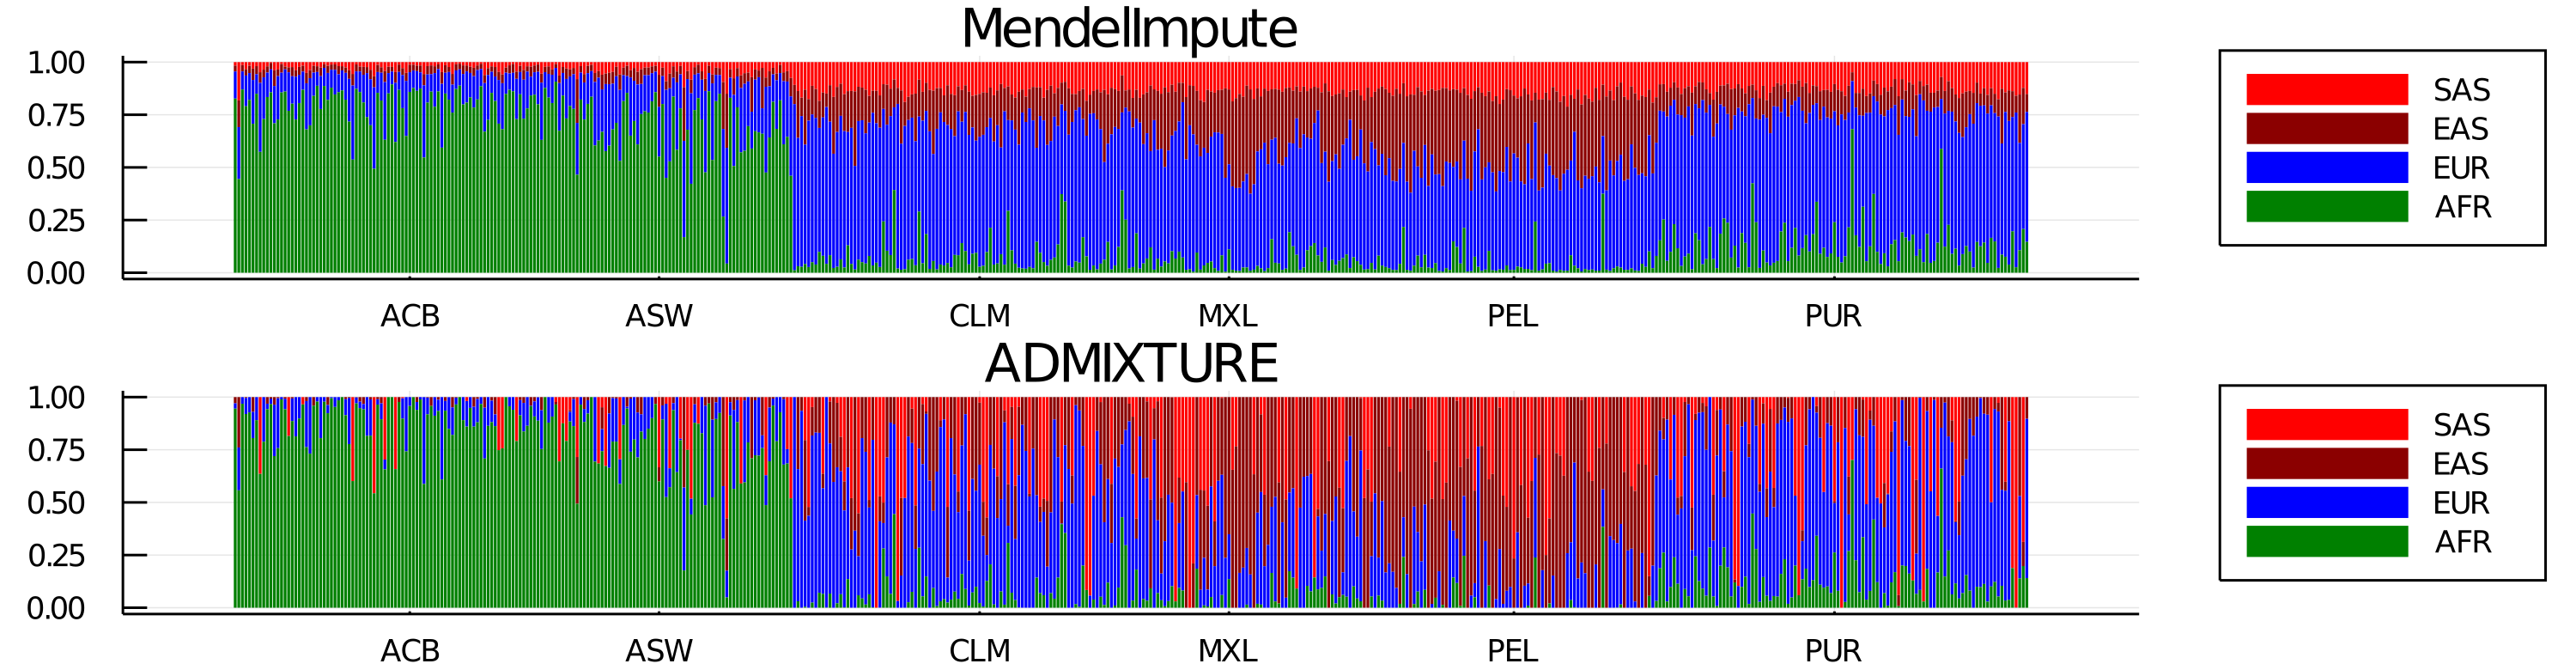

In [46]:
chr = 12

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 13

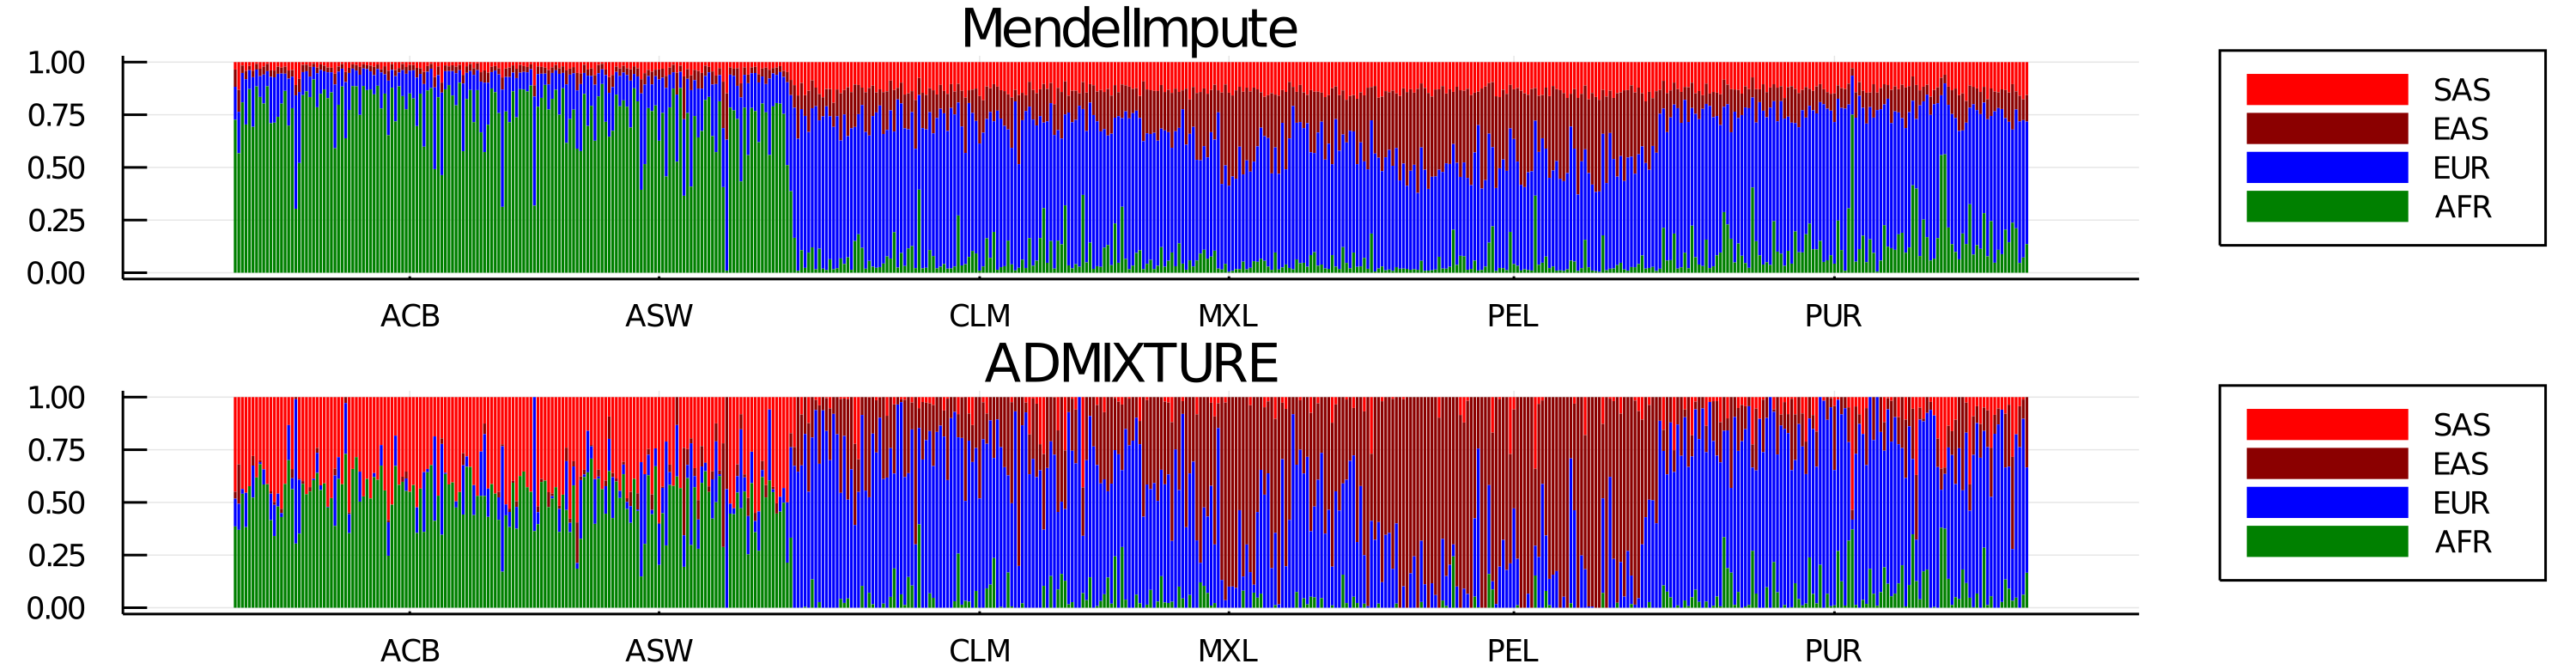

In [68]:
chr = 13

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 14

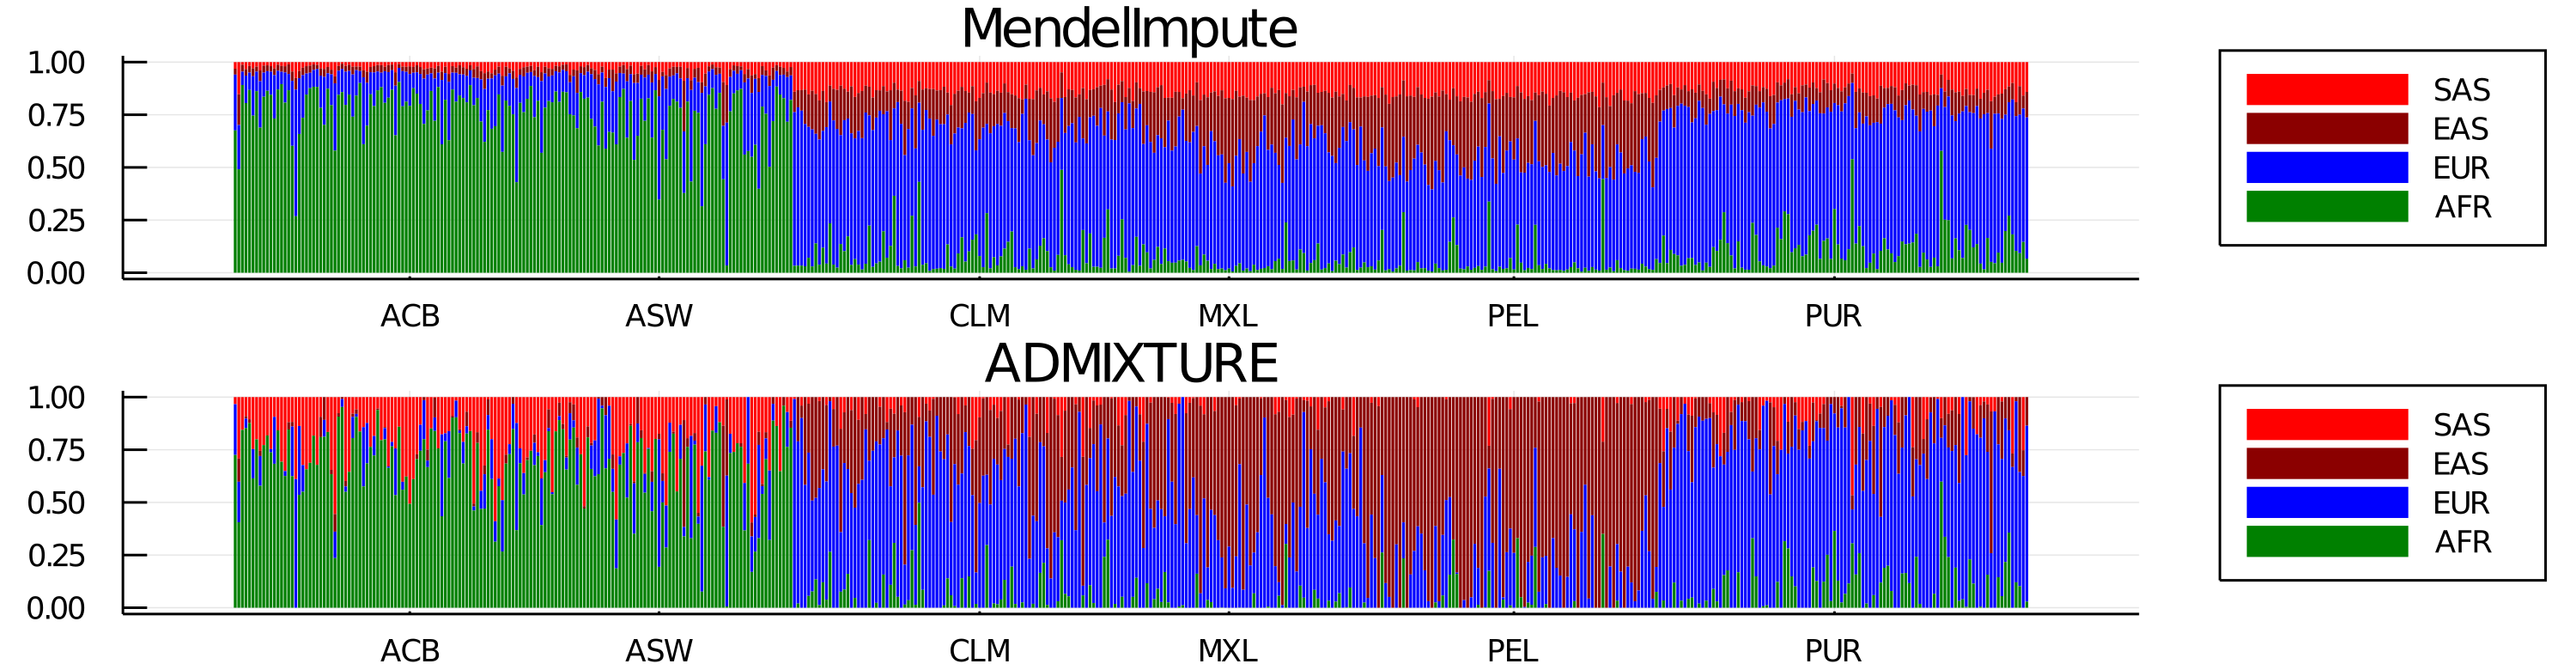

In [48]:
chr = 14

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 15

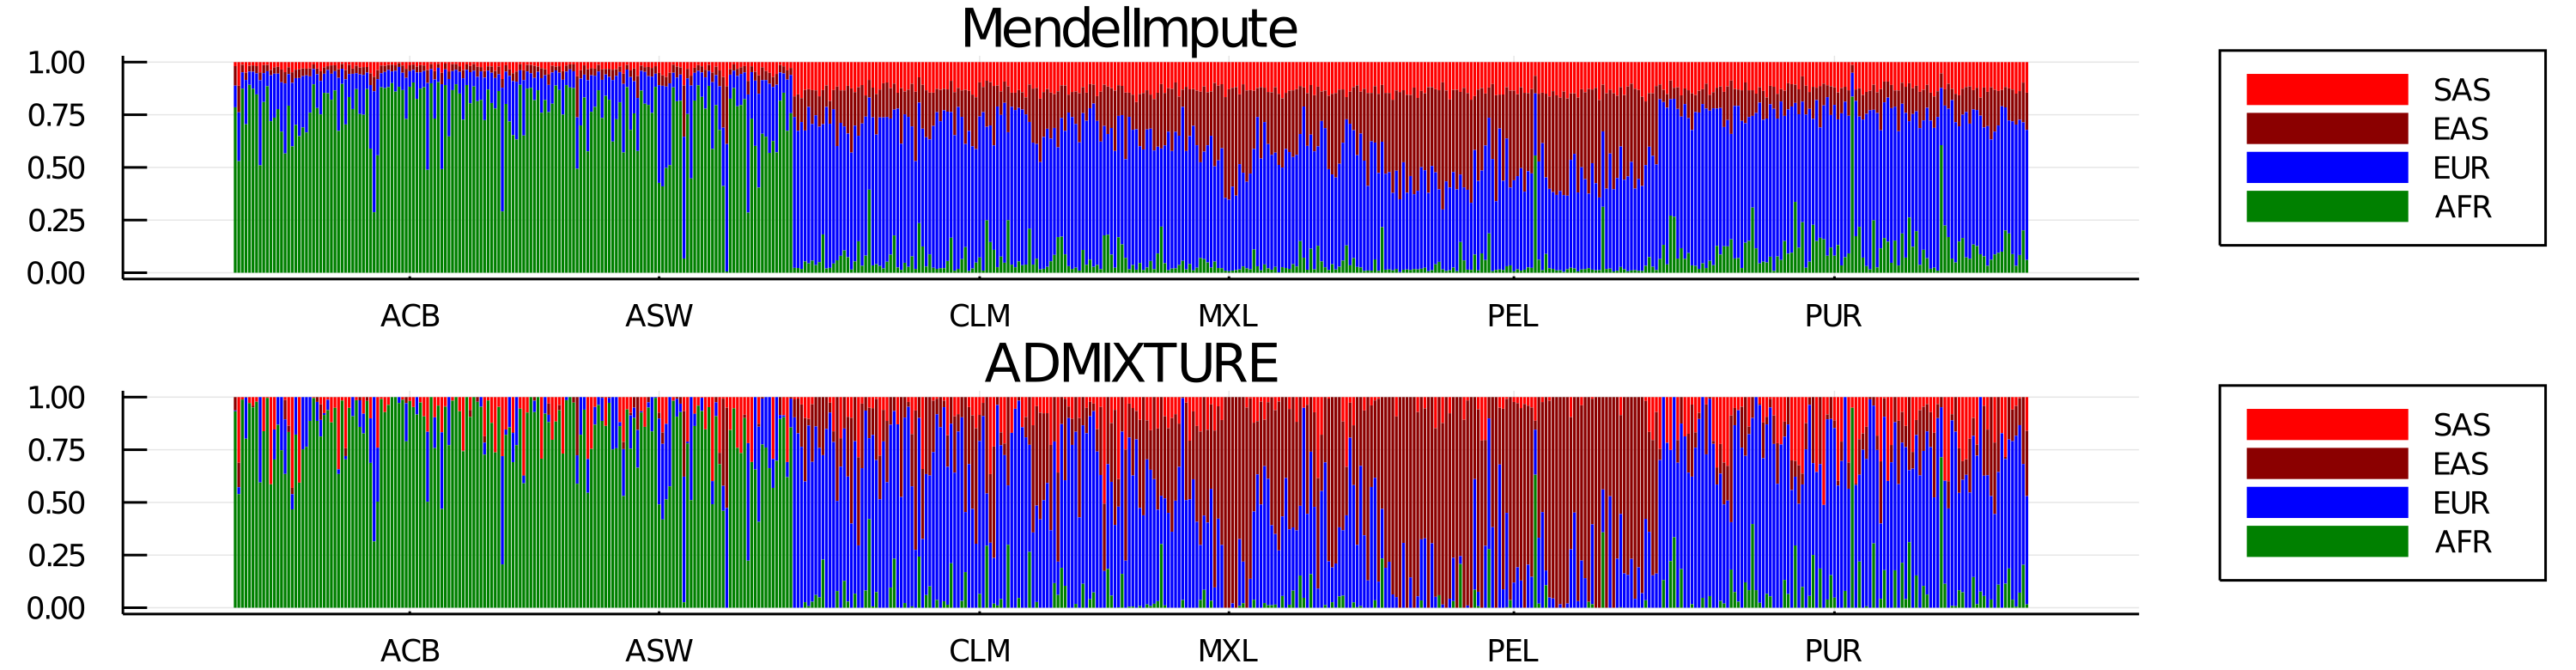

In [49]:
chr = 15

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 16

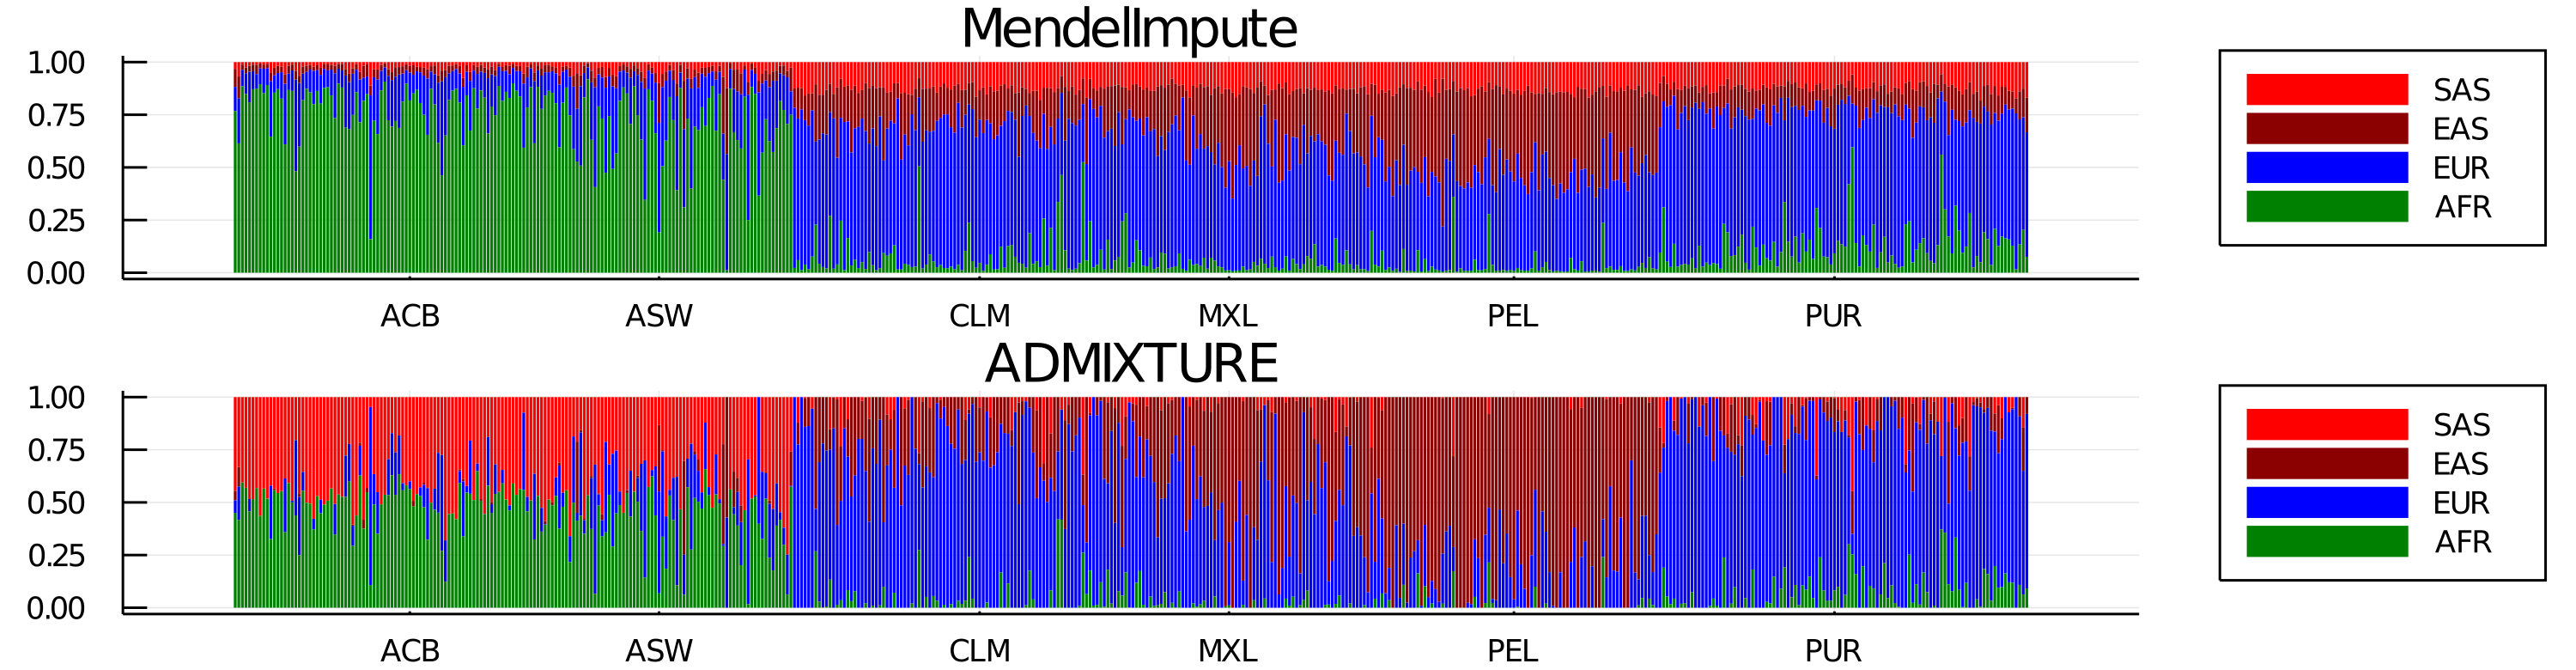

In [50]:
chr = 16

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 17

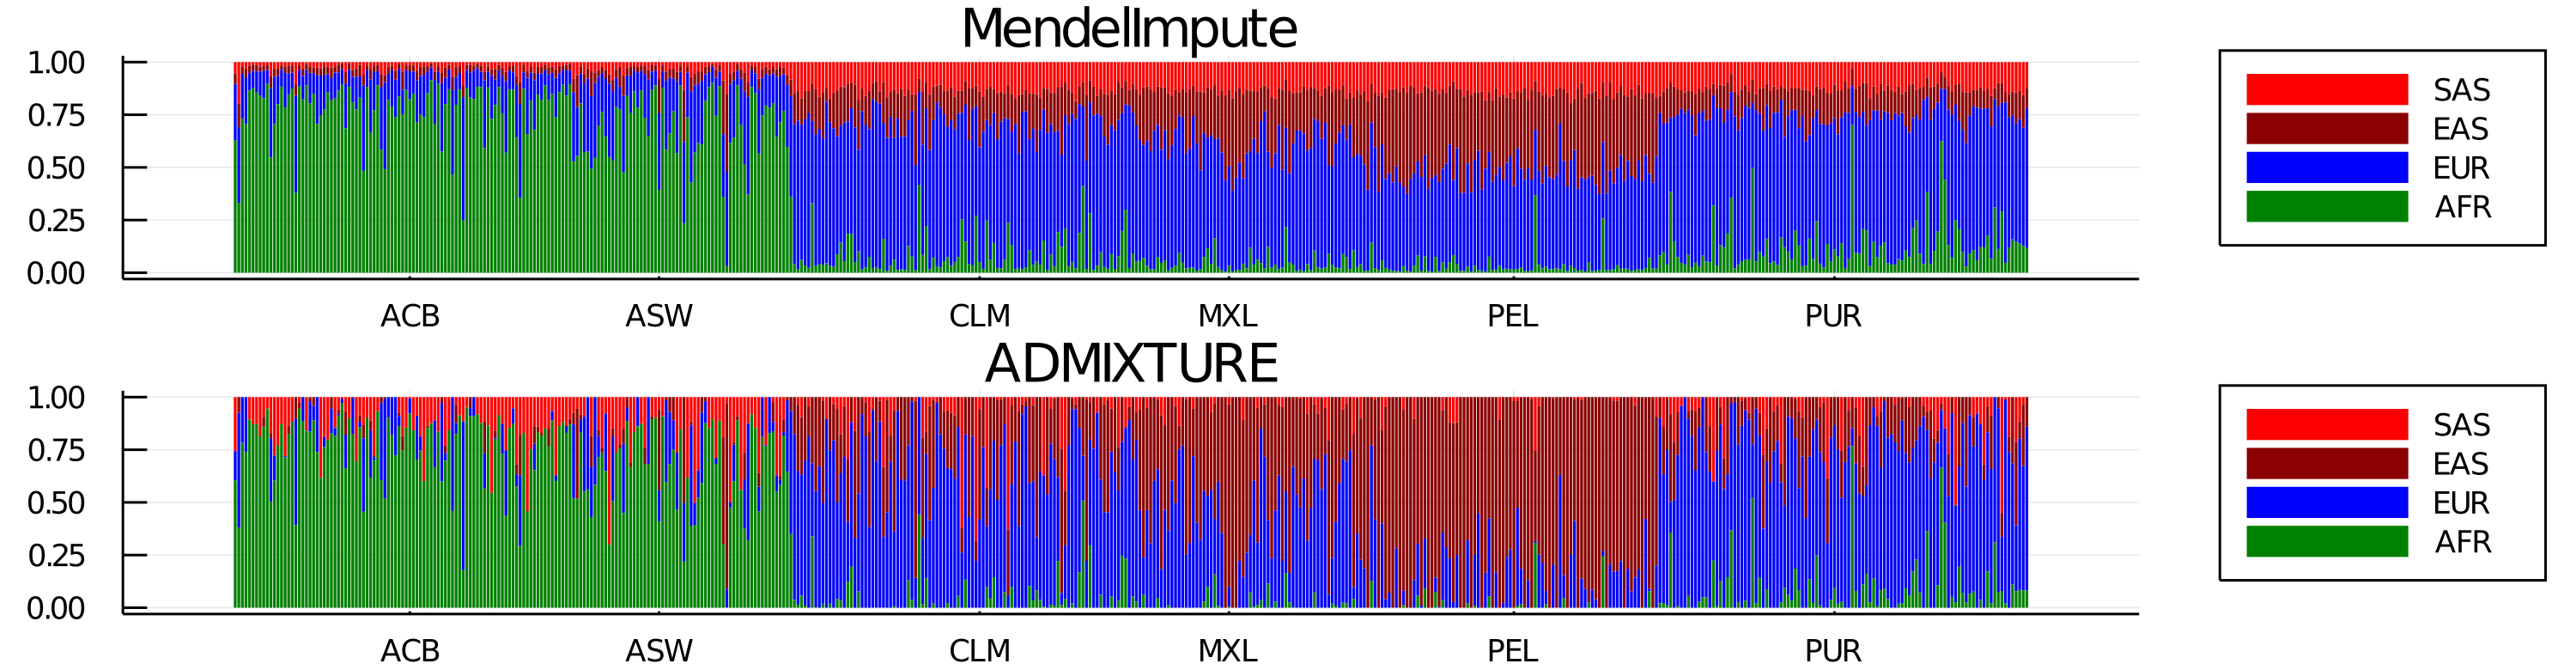

In [69]:
chr = 17

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 18

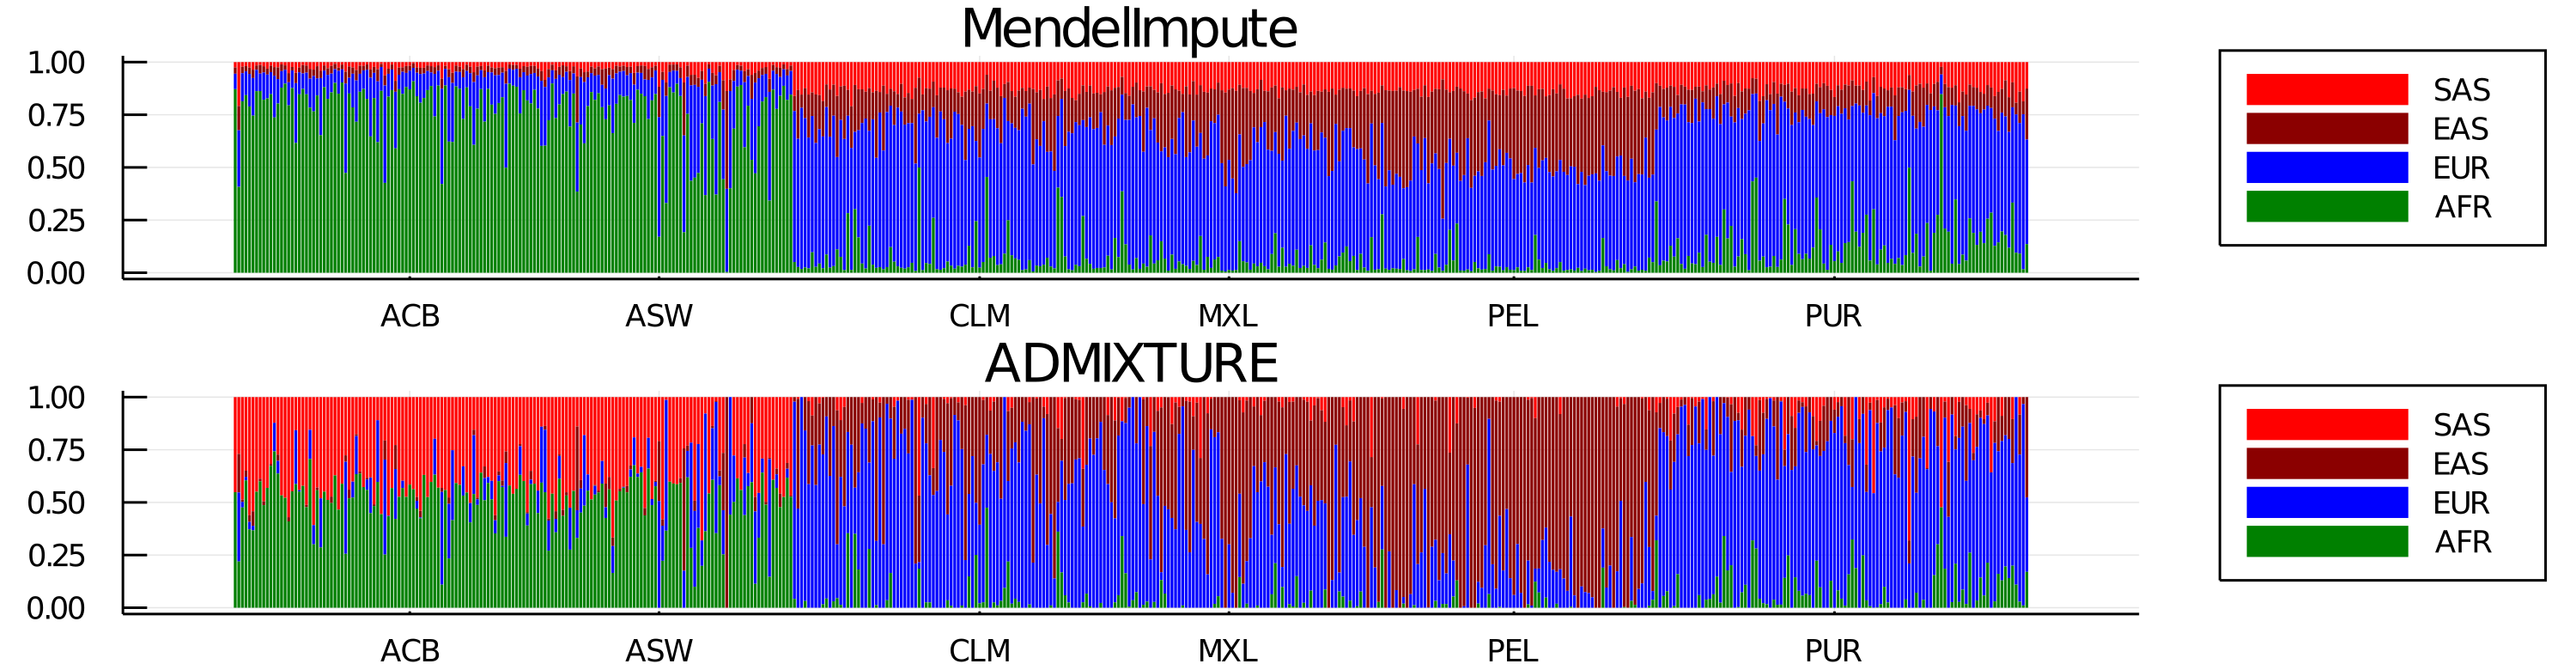

In [70]:
chr = 18

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 19

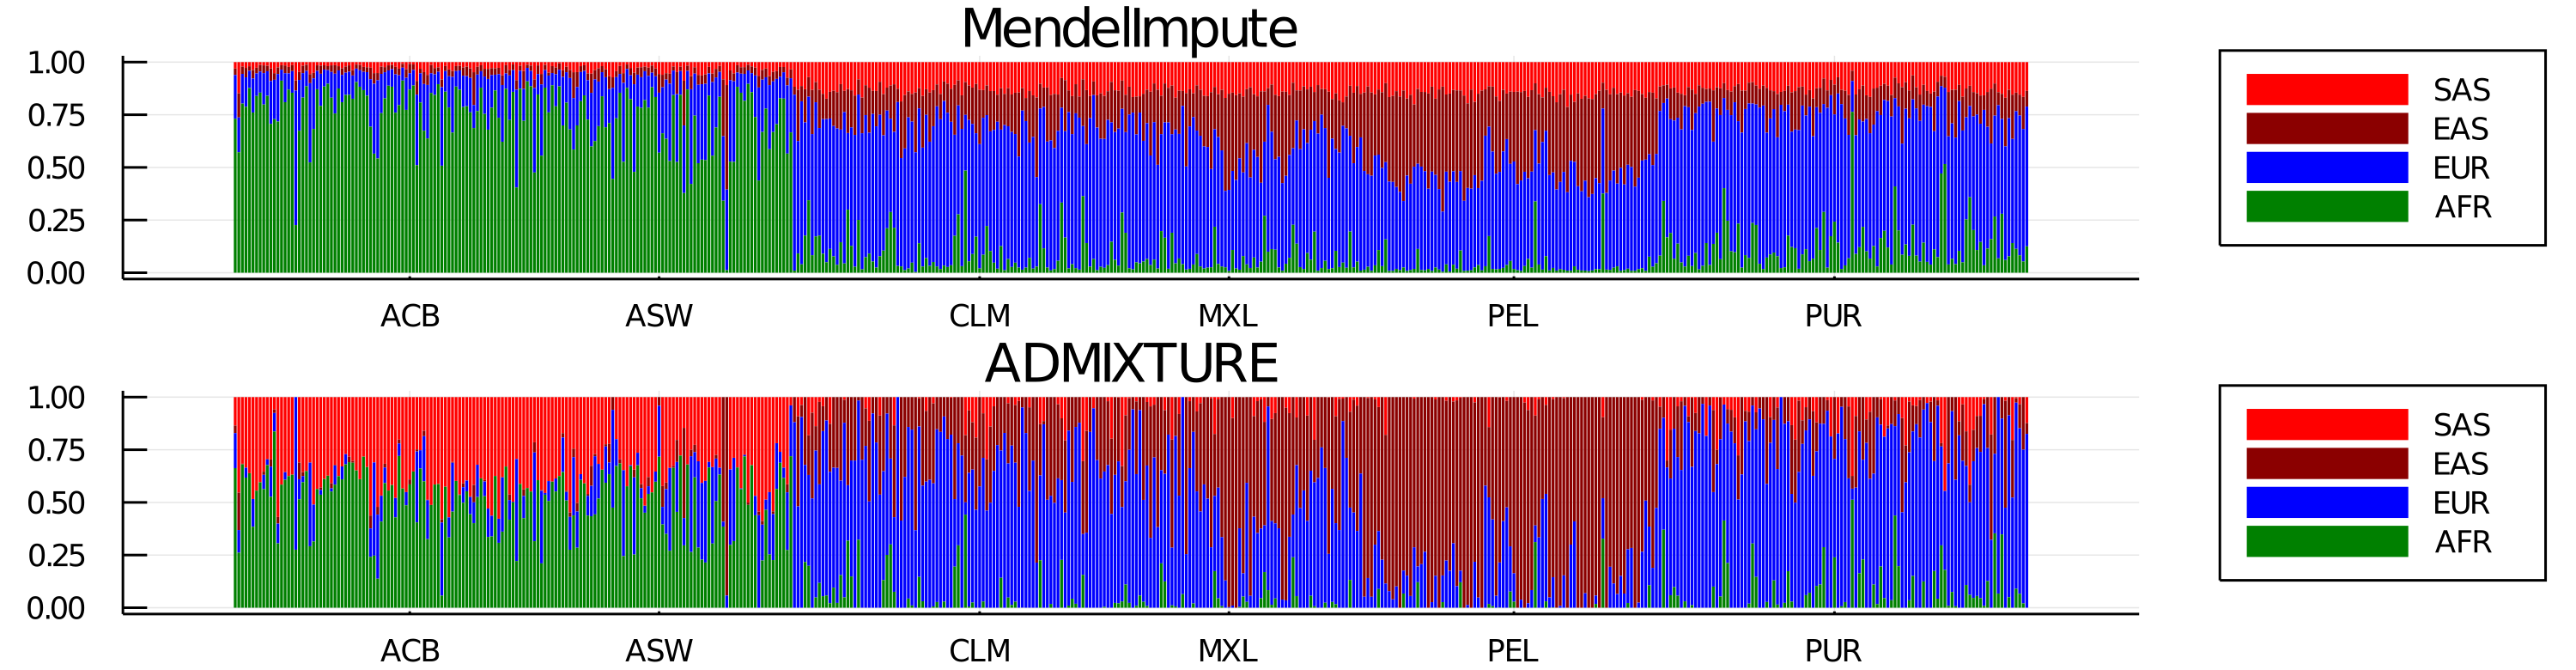

In [53]:
chr = 19

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q1 q4 q2 q3], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 20

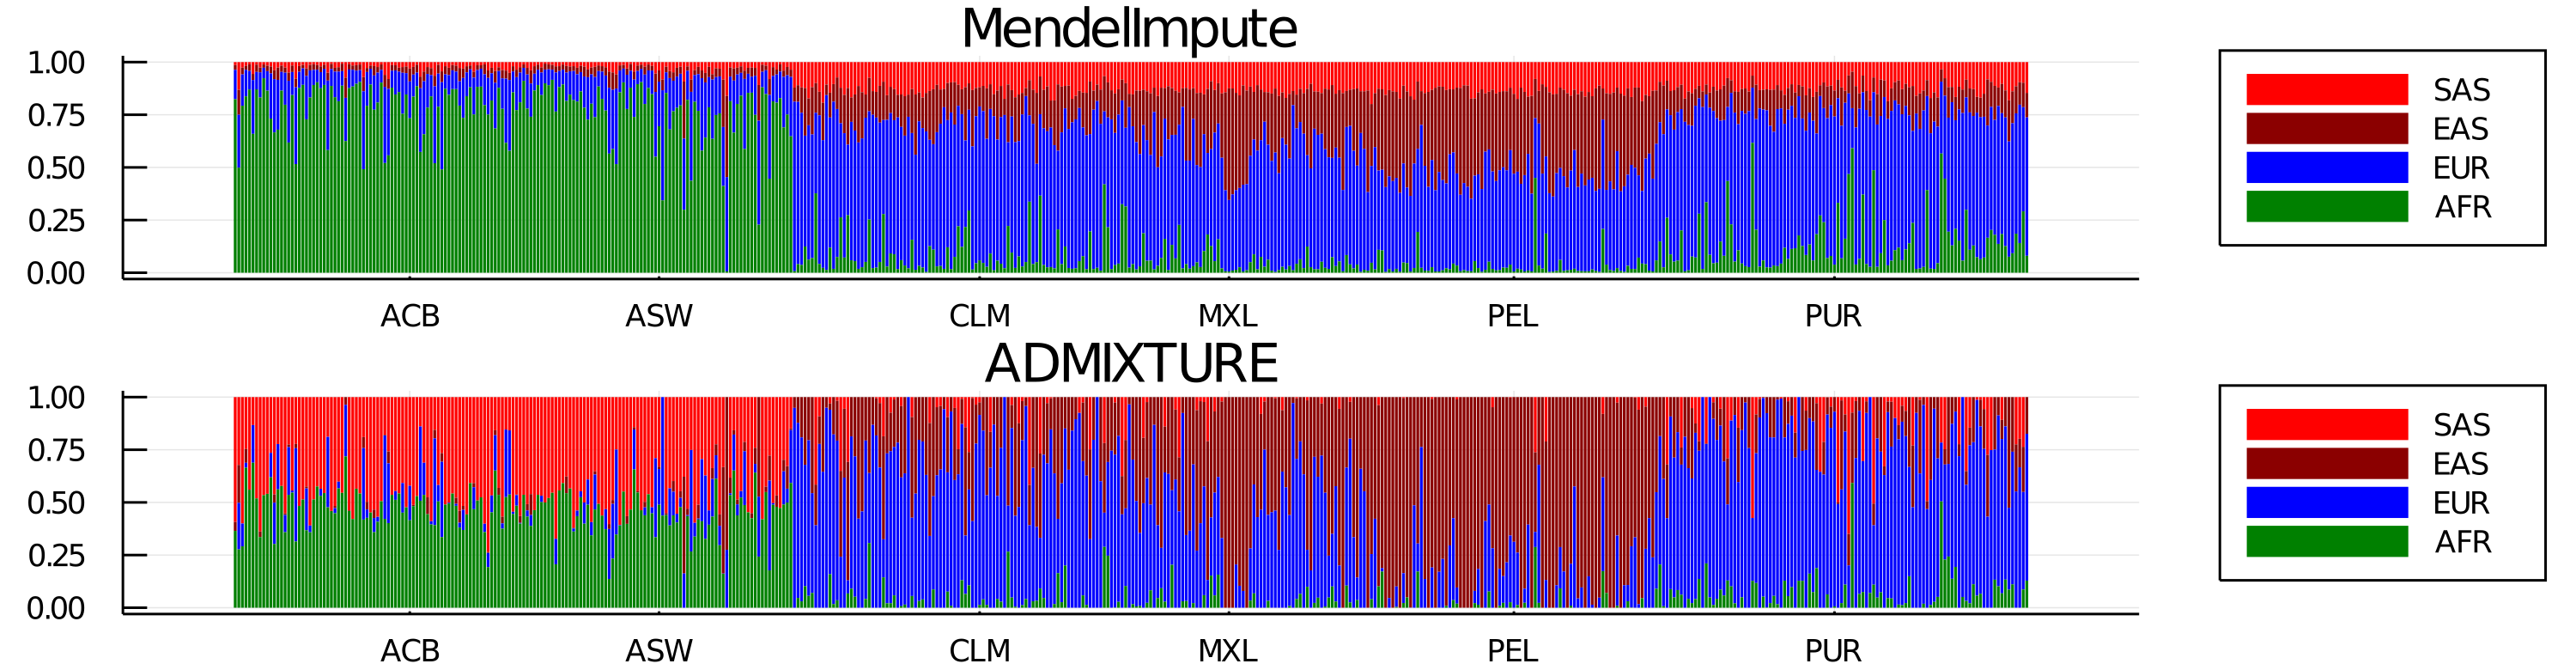

In [73]:
chr = 20

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 21

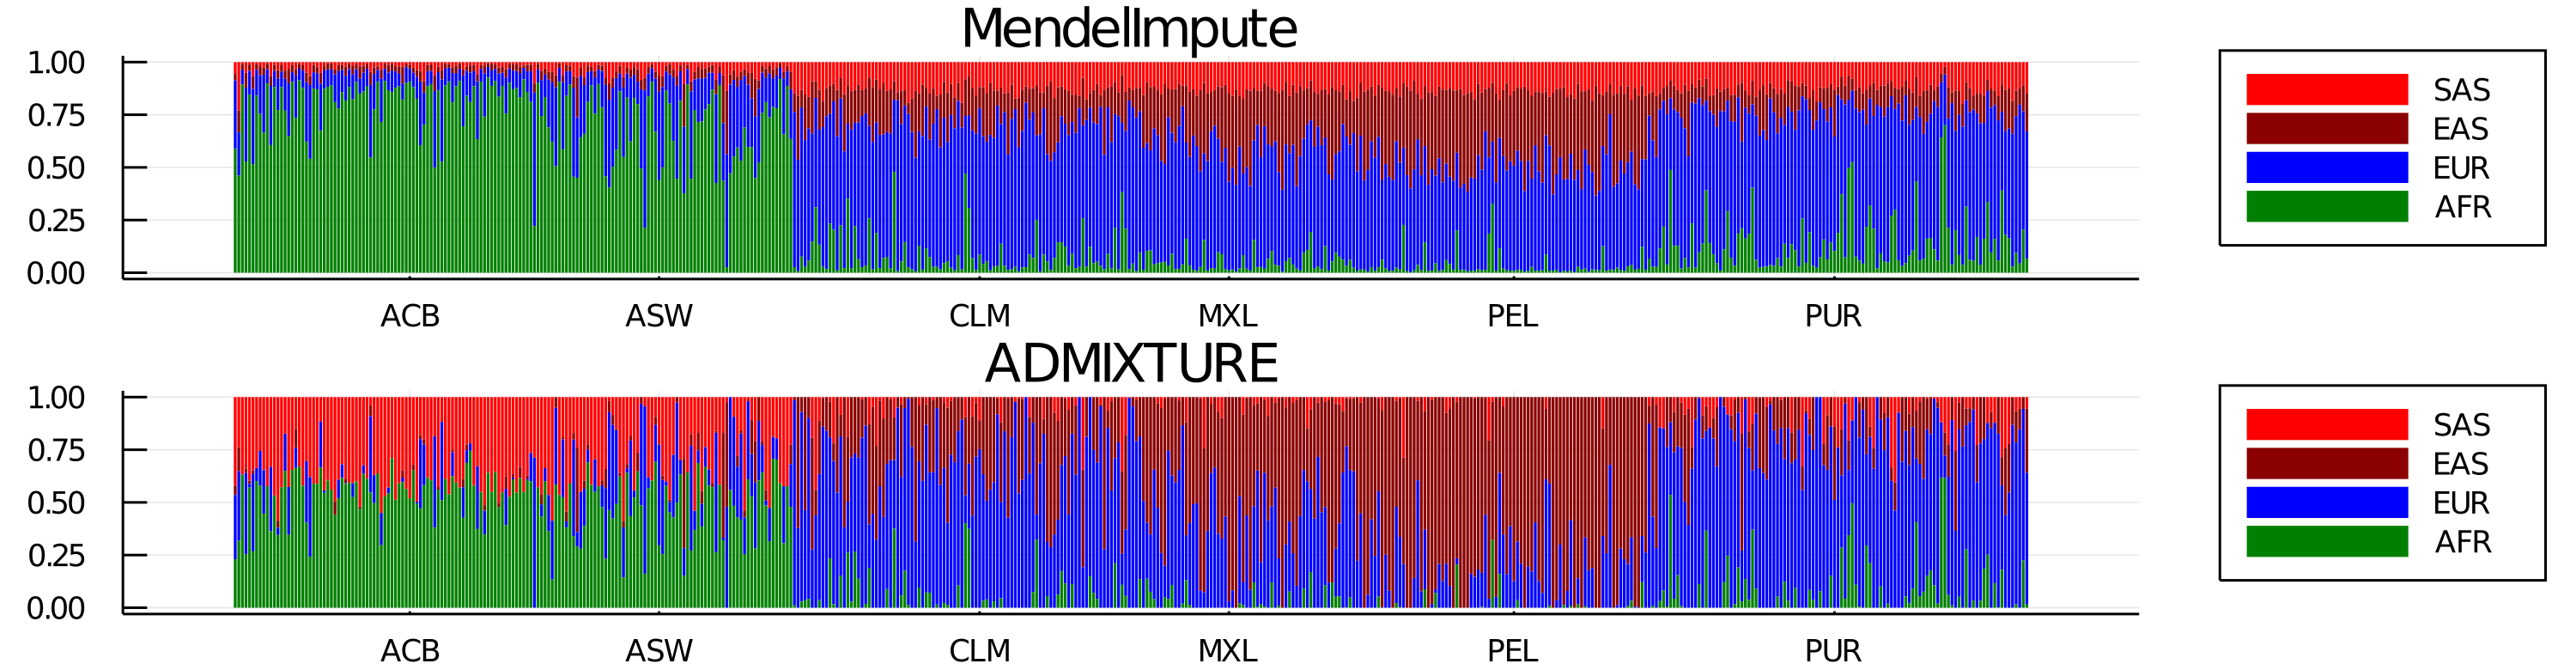

In [74]:
chr = 21

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))

## Chrom 22

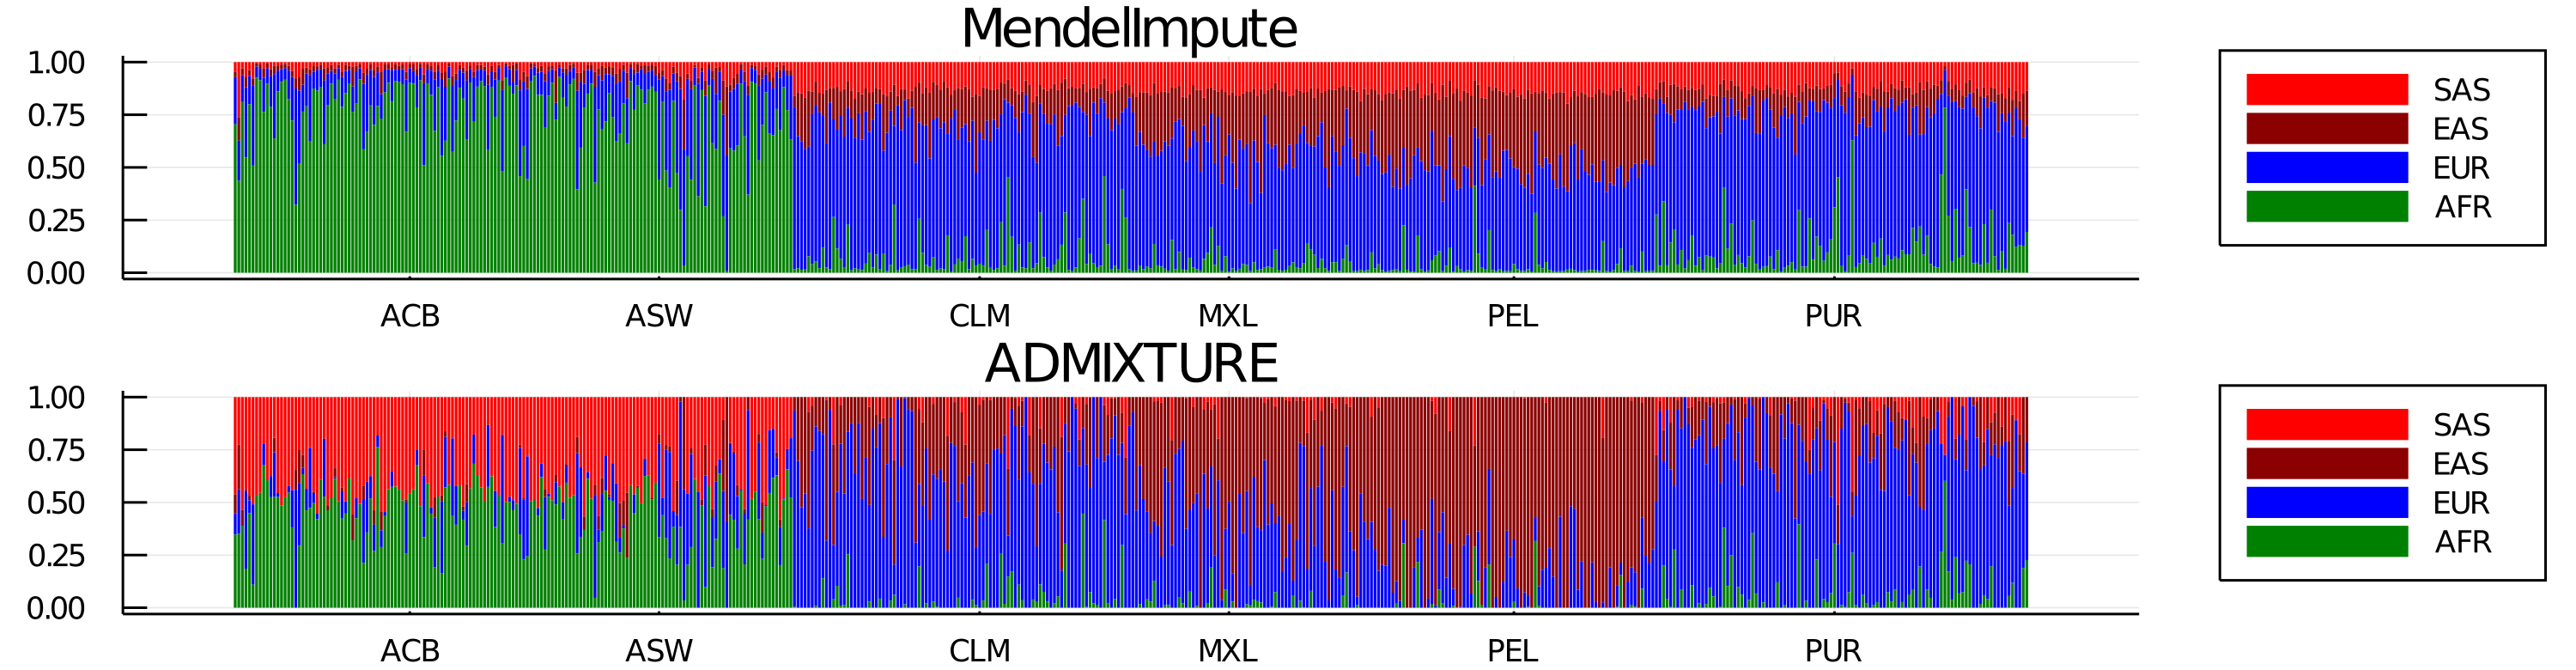

In [75]:
chr = 22

# MendelImpute
Q_mendel = CSV.read("mendelimpute.chr$chr.ancestry.Q", DataFrame)
pop_labels = names(Q_mendel)
Q_mendel = Matrix(Q_mendel)
plt1 = groupedbar(Q_mendel[p, :], linecolor=nothing,
    bar_position = :stack, size=(1000, 130), title="MendelImpute",
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

# ADMIXTURE
Q_admixture = readdlm("target.chr$chr.typedOnly.aim.masked.4.Q")[p, :]
q1, q2, q3, q4 = Q_admixture[:, 1], Q_admixture[:, 2], Q_admixture[:, 3], Q_admixture[:, 4]
plt2 = groupedbar([q3 q4 q2 q1], linecolor=nothing, bar_position = :stack, 
    title="ADMIXTURE", size=(1000, 130),
    label=["SAS" "EAS" "EUR" "AFR"], legend = :outerright,
    xticks=([50, 120, 210, 280, 360, 450], unique(sort(tgt_pop))), color=[:red :darkred :blue :green])

plt = plot(plt1, plt2, layout=(2, 1), size=(1000, 260), dpi=300)
savefig(plt, "chr$chr.comparison.png")
display("image/png", read("chr$chr.comparison.png"))